This notebook is used to create a trajectory plot for all benchmarks of tasks belonging to NLP.

It consists of 115 tasks and a total of 383 unique benchmarks. Some times one benchmark can be used to evaluate different tasks.

705 models have been reported and a total of 175 different metrics have been collected

--

There is a major change here. We have used the ratio of the gain for the trajectories. In the last example, we exclude the anchor dots and also trajectories tha have only one datapoint.

Finally, we have normalized the averaged dataframe to a percentual of the sum of the datapoints. Then, we clustered the dataframe, plot the heatmap and reordered it according to the hierarchical clustering table. 

In [1]:
# Load modules
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, N3, JSON
from rdflib import Graph
import plotly.graph_objects as go
import plotly.express as px
import re
#! pip install -U kaleido
#! pip install psutil

# setup some pandas display modes
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 5)
pd.set_option("display.max_colwidth", None)

%matplotlib inline

## Load the data frame

In [2]:
# Read query results from CSV file
get_ratio_df_all_per_global = pd.read_csv("get_ratio_df_all_per_global1.csv")

# drop first column
get_ratio_df_all_per_global = get_ratio_df_all_per_global.drop(["Unnamed: 0"], axis=1)


# change the column to name the facets of the plot
get_ratio_df_all_per_global = get_ratio_df_all_per_global.rename(
    columns={"merge": "metricName"}
)
get_ratio_df_all_per_global["metricName"] = get_ratio_df_all_per_global[
    "metricName"
].str.replace("\\", "")

get_ratio_df_all_per_global["unique_ds"] = (
    get_ratio_df_all_per_global["ds"].astype(str)
    + ", "
    + get_ratio_df_all_per_global["metricName"]
)
get_ratio_df_all_per_global["unique_task"] = (
    get_ratio_df_all_per_global["task"].astype(str)
    + ", "
    + get_ratio_df_all_per_global["metricName"]
)

get_ratio_df_all_per_global["unique_task_ds_metric"] = (
    get_ratio_df_all_per_global["task"].astype(str)
    + ", "
    + get_ratio_df_all_per_global["ds"].astype(str)
    + ", "
    + get_ratio_df_all_per_global["metricName"]
)

# plot unique metricName
pd.DataFrame(get_ratio_df_all_per_global["metricName"].unique())

<ipython-input-2-2e5f5b796e0a>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  get_ratio_df_all_per_global["metricName"] = get_ratio_df_all_per_global[


0
0    1 in 10 R-at-1
1                F1
..              ...
174              DE
175              BA

[176 rows x 1 columns]

## Prepare the data frame

In [3]:
#calculate average data frame using 'RATIO' as criteria FOR unique_task
#This graph is fine, however, it will display overlapped datasets used for the same task in the same trajectory.
traj = get_ratio_df_all_per_global.copy()

#task causing some problems
traj = traj.drop(traj[traj["metricName"]=="Parameters"].index)
#traj = traj.drop(traj[traj["unique_task"]=="Natural Language Inference, Parameters"].index)

#Process date field
#traj["date"]=pd.to_datetime(traj["date"]).dt.year

#traj["date"] = pd.to_datetime(traj["date"]).dt.strftime('%Y-%m')


In [4]:
# This will drop cases where the single points that represents ratio = 100%.
# traj = traj.drop(traj[traj["ratio"]==1].index)

In [5]:
# this will delete from the traj data frame, all the ds/tasks which the counts are equal to 1
# pd.set_option("display.max_rows", None)
count_df = pd.DataFrame(traj["ds"].value_counts())
count_df[count_df.ds == 1].index
# the symbol ~ selects reverse to .isin
traj = traj[~traj["ds"].isin(count_df[count_df.ds == 1].index)]

count_df = pd.DataFrame(traj["task"].value_counts())
count_df[count_df.task == 1].index

traj = traj[~traj["task"].isin(count_df[count_df.task == 1].index)]
pd.DataFrame(traj["ds"].value_counts())

ds
CNN / Daily Mail                47
SemEval 2014 Task 4 Sub Task 2  33
...                             ..
TREC-PM                          1
Amazon-5                         1

[250 rows x 1 columns]

## Plot using Ratio for Task

In [6]:
# this function is declared to add the anchor dots (white dots) to the trajectory
def add_white(category):
    fig.add_trace(
        go.Scatter(
            x=average_summary_OUT["date"],
            y=average_summary_OUT[category],
            mode="markers",
            name=None,
            marker=dict(
                size=10,
                color="white",
                # opacity=0.5,
            ),
            hovertemplate=average_summary_OUT[category]
            + "<BR>category: "
            + average_summary_OUT[category]
            + "<BR>date: "
            + average_summary_OUT["date"].astype("string")
            + "<BR>ratio: "
            + average_summary_OUT["ratio"].astype("string"),
        )
    )

### Plot with anchor and at east two points per trajectory

In [7]:
# variable_to_plot = "ratio"
# choose here which grouping variable to use
average_summary = pd.DataFrame(traj.groupby(["task", "date"])["ratio"].mean())

# DROP anchors
# average_summary = average_summary.drop(average_summary[average_summary["ratio"]>0.5].index)


average_summary.sort_values(by=["date"], ascending=True)

average_summary.reset_index(inplace=True)
# average_summary["date"]=pd.to_datetime(average_summary['date'])
# average_summary["date"]=average_summary["date"].dt.year
average_summary["in_trajectory"] = 1


i = 0
for t in average_summary.task.unique():
    sota_per = 0
    # here the date can't be unique, because we want to look for the best value per year
    for v in average_summary[average_summary["task"] == t].ratio:
        per = average_summary[
            (average_summary["task"] == t) & (average_summary["ratio"] == v)
        ].ratio.astype(float)
        per = per.iloc[0]
        if per >= sota_per:
            # print(per)
            sota_per = per
            average_summary.loc[i, "in_trajectory"] = "IN"
        else:
            # average_summary = average_summary.drop(i)
            average_summary.loc[i, "in_trajectory"] = "IN"  # change back to OUT
            # sota_per = per
        i = i + 1

# Add OUT to high gain values, normally those of the first results. They will be displayed as white dots.

# NOTE
# Ignore this for heatmap
average_summary.loc[average_summary["ratio"] > 0.5, "in_trajectory"] = "OUT"

average_summary["ratio"] = average_summary["ratio"].apply(lambda x: round(x, 2))
# average_summary = average_summary.rename(columns={'gain': 'gain'})

# needs to rename here to average of percentage of maximum sota


###NOW PLOT IT
# try using plotly
import pandas as pd
import plotly.express as px
from plotly.validators.scatter.marker import SymbolValidator

average_summary_IN = average_summary[average_summary["in_trajectory"] == "IN"]
average_summary_OUT = average_summary[average_summary["in_trajectory"] == "OUT"]

fig = px.line(average_summary_IN, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

add_white("task")

fig.add_trace(
    go.Scatter(
        x=average_summary_IN["date"],
        y=average_summary_IN["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN["task"]
        + "<BR>task: "
        + average_summary_IN["task"]
        + "<BR>date: "
        + average_summary_IN["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN["ratio"],  # set color equal to a variable
            colorscale="YlGn",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig.update_layout(
    #title="Trajectory for ratio (task per year)",
    title_text='Trajectory for ratio (task per year).<BR><BR>Anchor points (ratio>0.5) as white circles, trajectories with single arrow displayed.',
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)
fig.show()

In [8]:
# This shows the points that will be added as arrows to the graph: IN
average_summary.head()

task     date  ratio in_trajectory
0  Abstractive Text Summarization  2017-04   0.84           OUT
1  Abstractive Text Summarization  2019-05   0.40            IN
2  Abstractive Text Summarization  2019-12   0.03            IN
3  Abstractive Text Summarization  2020-01   0.01            IN
4    Ad-Hoc Information Retrieval  2017-04   0.87           OUT

In [9]:
# This block will take the values from average_summary_IN and delete those that have only one arrow per trajectory
count_df = pd.DataFrame(average_summary_IN["task"].value_counts())
count_df[count_df.task == 1].index
average_summary_IN = average_summary_IN[
    ~average_summary_IN["task"].isin(count_df[count_df.task == 1].index)
]
# this will delete from the traj data frame, all the tasks which the average_summary_IN counts are equal to 1
# meaning single arrows will be excluded from the plot

### Same plot as before, but then, only with more than one arrow per trajectory.

In [10]:
fig_traj = px.line(average_summary_IN, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

# This adds/remove those points with value < 1 and > 0.5
# add_white("task")

fig_traj.add_trace(
    go.Scatter(
        x=average_summary_IN["date"],
        y=average_summary_IN["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN["task"]
        + "<BR>task: "
        + average_summary_IN["task"]
        + "<BR>date: "
        + average_summary_IN["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN["ratio"],  # set color equal to a variable
            colorscale="YlGn",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig_traj.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig_traj.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig_traj.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig_traj.update_layout(
    #title="Trajectory for ratio (task per year)",
    title_text='Trajectory for ratio (task per year).<BR><BR>Anchor points (ratio>0.5) removed, trajectories with single arrow removed.',
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)

fig_traj.show()

In [11]:
#This sets cose to zero values equal to 0.001 in the trajectory.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

average_summary_IN.loc[(average_summary_IN['ratio'] == 0), "ratio"] = 0.001

average_summary_IN

task     date  ratio in_trajectory
1           Abstractive Text Summarization  2019-05  0.400            IN
2           Abstractive Text Summarization  2019-12  0.030            IN
3           Abstractive Text Summarization  2020-01  0.010            IN
6             Ad-Hoc Information Retrieval  2018-09  0.001            IN
7             Ad-Hoc Information Retrieval  2018-10  0.001            IN
8             Ad-Hoc Information Retrieval  2018-12  0.001            IN
9             Ad-Hoc Information Retrieval  2019-03  0.001            IN
10            Ad-Hoc Information Retrieval  2019-04  0.100            IN
13         Aspect-Based Sentiment Analysis  2016-05  0.050            IN
15         Aspect-Based Sentiment Analysis  2017-09  0.020            IN
16         Aspect-Based Sentiment Analysis  2018-02  0.010            IN
17         Aspect-Based Sentiment Analysis  2018-04  0.040            IN
18         Aspect-Based Sentiment Analysis  2018-05  0.010            IN
19         Aspect-Based Sentiment Analysis  2018-06  0.010            IN
20         Aspect-Based Sentiment Analysis  2018-10  0.020            IN
21         Aspect-Based Sentiment Analysis  2019-02  0.020            IN
23         Aspect-Based Sentiment Analysis  2019-04  0.010            IN
24         Aspect-Based Sentiment Analysis  2019-06  0.010            IN
25         Aspect-Based Sentiment Analysis  2019-08  0.030            IN
26         Aspect-Based Sentiment Analysis  2019-12  0.020            IN
27         Aspect-Based Sentiment Analysis  2020-04  0.010            IN
31        Chinese Named Entity Recognition  2019-07  0.010            IN
32        Chinese Named Entity Recognition  2019-10  0.050            IN
33        Chinese Named Entity Recognition  2019-11  0.020            IN
38                                Chunking  2016-11  0.001            IN
39                                Chunking  2018-08  0.010            IN
41          Citation Intent Classification  2016-06  0.160            IN
42          Citation Intent Classification  2018-01  0.480            IN
43          Citation Intent Classification  2018-02  0.020            IN
44          Citation Intent Classification  2019-03  0.110            IN
45          Citation Intent Classification  2019-04  0.030            IN
47          Constituency Grammar Induction  2018-08  0.450            IN
48          Constituency Grammar Induction  2018-10  0.270            IN
49          Constituency Grammar Induction  2019-04  0.040            IN
50          Constituency Grammar Induction  2019-06  0.060            IN
52                    Constituency Parsing  2016-11  0.020            IN
53                    Constituency Parsing  2017-01  0.001            IN
54                    Constituency Parsing  2017-07  0.010            IN
55                    Constituency Parsing  2018-05  0.010            IN
56                    Constituency Parsing  2019-03  0.010            IN
58       Conversational Response Selection  2019-01  0.050            IN
60       Conversational Response Selection  2019-11  0.100            IN
62                  Coreference Resolution  2016-06  0.010            IN
63                  Coreference Resolution  2016-09  0.010            IN
65                  Coreference Resolution  2018-02  0.040            IN
66                  Coreference Resolution  2018-04  0.030            IN
67                  Coreference Resolution  2019-07  0.040            IN
69             Cross-Lingual Bitext Mining  2018-11  0.180            IN
70             Cross-Lingual Bitext Mining  2018-12  0.010            IN
72   Cross-Lingual Document Classification  2014-04  0.030            IN
73   Cross-Lingual Document Classification  2014-12  0.060            IN
75   Cross-Lingual Document Classification  2018-12  0.040            IN
76   Cross-Lingual Document Classification  2019-09  0.090            IN
81                 Data-to-Text Generation  2018-03  0.040            IN
82                 Data

In [12]:
average_summary_IN.loc[(average_summary_IN['ratio'] == 0), "ratio"] = 0.001

# CLUSTERING

In [13]:
#Input of the clustering step: no anchors and no single point trajectory
average_summary_IN.head(5)

task     date  ratio in_trajectory
1  Abstractive Text Summarization  2019-05  0.400            IN
2  Abstractive Text Summarization  2019-12  0.030            IN
3  Abstractive Text Summarization  2020-01  0.010            IN
6    Ad-Hoc Information Retrieval  2018-09  0.001            IN
7    Ad-Hoc Information Retrieval  2018-10  0.001            IN

In [14]:
#melt the data frame to prepare data
df_melted = pd.melt(average_summary_IN, id_vars=["task", "date"], value_vars=["ratio"])

#set numeric column to float
df_melted["value"] = df_melted["value"].astype(float)

#this sets the DS as leaves for the  clustering entities
df=pd.DataFrame(columns=df_melted["date"].unique())

df["task"]=df_melted["task"].unique()

df=df.set_index("task")


#fill the clustering df
#create this data frame to use for clustering, fill variables that are not available with 0
#df_melted["value"] = df_melted["value"].astype(float)
for ds in df_melted["task"].unique():
    for var in df_melted["date"].unique():
    #print(ds)
        value = df_melted[(df_melted["task"]==ds)&(df_melted["date"]==var)]["value"]
        if(len(value)>0):
            print(ds,"\t",var,"\t",value.iloc[0])
            df.loc[ds,var] = value.iloc[0]
            #df = df.append(pd.Series({var: value}, name=ds))
        else:
            print(ds,"\t",var,"\t0",)
            #df(ds)[var] = "NaN"
            #df = df.append(pd.Series({var: "NaN"}, name=ds))   


Abstractive Text Summarization 	 2019-05 	 0.4
Abstractive Text Summarization 	 2019-12 	 0.03
Abstractive Text Summarization 	 2020-01 	 0.01
Abstractive Text Summarization 	 2018-09 	0
Abstractive Text Summarization 	 2018-10 	0
Abstractive Text Summarization 	 2018-12 	0
Abstractive Text Summarization 	 2019-03 	0
Abstractive Text Summarization 	 2019-04 	0
Abstractive Text Summarization 	 2016-05 	0
Abstractive Text Summarization 	 2017-09 	0
Abstractive Text Summarization 	 2018-02 	0
Abstractive Text Summarization 	 2018-04 	0
Abstractive Text Summarization 	 2018-05 	0
Abstractive Text Summarization 	 2018-06 	0
Abstractive Text Summarization 	 2019-02 	0
Abstractive Text Summarization 	 2019-06 	0
Abstractive Text Summarization 	 2019-08 	0
Abstractive Text Summarization 	 2020-04 	0
Abstractive Text Summarization 	 2019-07 	0
Abstractive Text Summarization 	 2019-10 	0
Abstractive Text Summarization 	 2019-11 	0
Abstractive Text Summarization 	 2016-11 	0
Abstractive Text Summ

Citation Intent Classification 	 2019-06 	0
Citation Intent Classification 	 2019-08 	0
Citation Intent Classification 	 2020-04 	0
Citation Intent Classification 	 2019-07 	0
Citation Intent Classification 	 2019-10 	0
Citation Intent Classification 	 2019-11 	0
Citation Intent Classification 	 2016-11 	0
Citation Intent Classification 	 2018-08 	0
Citation Intent Classification 	 2016-06 	 0.16
Citation Intent Classification 	 2018-01 	 0.48
Citation Intent Classification 	 2017-01 	0
Citation Intent Classification 	 2017-07 	0
Citation Intent Classification 	 2019-01 	0
Citation Intent Classification 	 2016-09 	0
Citation Intent Classification 	 2018-11 	0
Citation Intent Classification 	 2014-04 	0
Citation Intent Classification 	 2014-12 	0
Citation Intent Classification 	 2019-09 	0
Citation Intent Classification 	 2018-03 	0
Citation Intent Classification 	 2016-03 	0
Citation Intent Classification 	 2018-07 	0
Citation Intent Classification 	 2017-11 	0
Citation Intent Classifi

Coreference Resolution 	 2017-03 	0
Coreference Resolution 	 2015-08 	0
Coreference Resolution 	 2014-06 	0
Coreference Resolution 	 2015-06 	0
Coreference Resolution 	 2015-11 	0
Coreference Resolution 	 2016-02 	0
Coreference Resolution 	 2016-01 	0
Coreference Resolution 	 2020-03 	0
Coreference Resolution 	 2015-02 	0
Coreference Resolution 	 2015-04 	0
Cross-Lingual Bitext Mining 	 2019-05 	0
Cross-Lingual Bitext Mining 	 2019-12 	0
Cross-Lingual Bitext Mining 	 2020-01 	0
Cross-Lingual Bitext Mining 	 2018-09 	0
Cross-Lingual Bitext Mining 	 2018-10 	0
Cross-Lingual Bitext Mining 	 2018-12 	 0.01
Cross-Lingual Bitext Mining 	 2019-03 	0
Cross-Lingual Bitext Mining 	 2019-04 	0
Cross-Lingual Bitext Mining 	 2016-05 	0
Cross-Lingual Bitext Mining 	 2017-09 	0
Cross-Lingual Bitext Mining 	 2018-02 	0
Cross-Lingual Bitext Mining 	 2018-04 	0
Cross-Lingual Bitext Mining 	 2018-05 	0
Cross-Lingual Bitext Mining 	 2018-06 	0
Cross-Lingual Bitext Mining 	 2019-02 	0
Cross-Lingual Bitext 

Dialog Act Classification 	 2017-06 	0
Dialog Act Classification 	 2014-08 	0
Dialog Act Classification 	 2017-02 	0
Dialog Act Classification 	 2017-03 	0
Dialog Act Classification 	 2015-08 	0
Dialog Act Classification 	 2014-06 	0
Dialog Act Classification 	 2015-06 	0
Dialog Act Classification 	 2015-11 	0
Dialog Act Classification 	 2016-02 	0
Dialog Act Classification 	 2016-01 	0
Dialog Act Classification 	 2020-03 	0
Dialog Act Classification 	 2015-02 	0
Dialog Act Classification 	 2015-04 	0
Dialog State Tracking 	 2019-05 	0
Dialog State Tracking 	 2019-12 	0
Dialog State Tracking 	 2020-01 	0
Dialog State Tracking 	 2018-09 	0
Dialog State Tracking 	 2018-10 	 0.01
Dialog State Tracking 	 2018-12 	0
Dialog State Tracking 	 2019-03 	0
Dialog State Tracking 	 2019-04 	0
Dialog State Tracking 	 2016-05 	0
Dialog State Tracking 	 2017-09 	0
Dialog State Tracking 	 2018-02 	0
Dialog State Tracking 	 2018-04 	0
Dialog State Tracking 	 2018-05 	 0.02
Dialog State Tracking 	 2018-0

Emotion Recognition in Conversation 	 2016-01 	0
Emotion Recognition in Conversation 	 2020-03 	0
Emotion Recognition in Conversation 	 2015-02 	0
Emotion Recognition in Conversation 	 2015-04 	0
Entity Disambiguation 	 2019-05 	0
Entity Disambiguation 	 2019-12 	0
Entity Disambiguation 	 2020-01 	0
Entity Disambiguation 	 2018-09 	0
Entity Disambiguation 	 2018-10 	0
Entity Disambiguation 	 2018-12 	0
Entity Disambiguation 	 2019-03 	0
Entity Disambiguation 	 2019-04 	0
Entity Disambiguation 	 2016-05 	0
Entity Disambiguation 	 2017-09 	0
Entity Disambiguation 	 2018-02 	0
Entity Disambiguation 	 2018-04 	0
Entity Disambiguation 	 2018-05 	0
Entity Disambiguation 	 2018-06 	0
Entity Disambiguation 	 2019-02 	0
Entity Disambiguation 	 2019-06 	0
Entity Disambiguation 	 2019-08 	0
Entity Disambiguation 	 2020-04 	0
Entity Disambiguation 	 2019-07 	0
Entity Disambiguation 	 2019-10 	0
Entity Disambiguation 	 2019-11 	0
Entity Disambiguation 	 2016-11 	0
Entity Disambiguation 	 2018-08 	0

Language Modelling 	 2018-03 	 0.26
Language Modelling 	 2016-03 	 0.06
Language Modelling 	 2018-07 	0
Language Modelling 	 2017-11 	 0.001
Language Modelling 	 2017-10 	 0.001
Language Modelling 	 2017-05 	 0.001
Language Modelling 	 2017-12 	0
Language Modelling 	 2017-04 	0
Language Modelling 	 2016-07 	 0.37
Language Modelling 	 2017-08 	 0.02
Language Modelling 	 2020-02 	 0.5
Language Modelling 	 2014-09 	0
Language Modelling 	 2014-10 	0
Language Modelling 	 2016-08 	0
Language Modelling 	 2016-10 	0
Language Modelling 	 2017-06 	0
Language Modelling 	 2014-08 	0
Language Modelling 	 2017-02 	0
Language Modelling 	 2017-03 	0
Language Modelling 	 2015-08 	0
Language Modelling 	 2014-06 	0
Language Modelling 	 2015-06 	0
Language Modelling 	 2015-11 	0
Language Modelling 	 2016-02 	0
Language Modelling 	 2016-01 	0
Language Modelling 	 2020-03 	0
Language Modelling 	 2015-02 	0
Language Modelling 	 2015-04 	0
Linguistic Acceptability 	 2019-05 	0
Linguistic Acceptability 	 2019-

Named Entity Recognition 	 2019-08 	0
Named Entity Recognition 	 2020-04 	0
Named Entity Recognition 	 2019-07 	 0.04
Named Entity Recognition 	 2019-10 	 0.03
Named Entity Recognition 	 2019-11 	0
Named Entity Recognition 	 2016-11 	0
Named Entity Recognition 	 2018-08 	 0.09
Named Entity Recognition 	 2016-06 	0
Named Entity Recognition 	 2018-01 	0
Named Entity Recognition 	 2017-01 	0
Named Entity Recognition 	 2017-07 	0
Named Entity Recognition 	 2019-01 	0
Named Entity Recognition 	 2016-09 	0
Named Entity Recognition 	 2018-11 	0
Named Entity Recognition 	 2014-04 	0
Named Entity Recognition 	 2014-12 	0
Named Entity Recognition 	 2019-09 	 0.04
Named Entity Recognition 	 2018-03 	0
Named Entity Recognition 	 2016-03 	0
Named Entity Recognition 	 2018-07 	0
Named Entity Recognition 	 2017-11 	0
Named Entity Recognition 	 2017-10 	0
Named Entity Recognition 	 2017-05 	0
Named Entity Recognition 	 2017-12 	0
Named Entity Recognition 	 2017-04 	0
Named Entity Recognition 	 2016-07

Open-Domain Question Answering 	 2016-07 	0
Open-Domain Question Answering 	 2017-08 	0
Open-Domain Question Answering 	 2020-02 	0
Open-Domain Question Answering 	 2014-09 	0
Open-Domain Question Answering 	 2014-10 	0
Open-Domain Question Answering 	 2016-08 	0
Open-Domain Question Answering 	 2016-10 	0
Open-Domain Question Answering 	 2017-06 	0
Open-Domain Question Answering 	 2014-08 	0
Open-Domain Question Answering 	 2017-02 	0
Open-Domain Question Answering 	 2017-03 	 0.05
Open-Domain Question Answering 	 2015-08 	0
Open-Domain Question Answering 	 2014-06 	0
Open-Domain Question Answering 	 2015-06 	0
Open-Domain Question Answering 	 2015-11 	0
Open-Domain Question Answering 	 2016-02 	0
Open-Domain Question Answering 	 2016-01 	0
Open-Domain Question Answering 	 2020-03 	0
Open-Domain Question Answering 	 2015-02 	0
Open-Domain Question Answering 	 2015-04 	0
Paraphrase Generation 	 2019-05 	0
Paraphrase Generation 	 2019-12 	0
Paraphrase Generation 	 2020-01 	0
Paraphrase 

Question Answering 	 2016-01 	0
Question Answering 	 2020-03 	0
Question Answering 	 2015-02 	0
Question Answering 	 2015-04 	0
Question Generation 	 2019-05 	 0.37
Question Generation 	 2019-12 	0
Question Generation 	 2020-01 	 0.05
Question Generation 	 2018-09 	0
Question Generation 	 2018-10 	0
Question Generation 	 2018-12 	0
Question Generation 	 2019-03 	0
Question Generation 	 2019-04 	0
Question Generation 	 2016-05 	0
Question Generation 	 2017-09 	0
Question Generation 	 2018-02 	0
Question Generation 	 2018-04 	0
Question Generation 	 2018-05 	0
Question Generation 	 2018-06 	 0.03
Question Generation 	 2019-02 	0
Question Generation 	 2019-06 	0
Question Generation 	 2019-08 	0
Question Generation 	 2020-04 	0
Question Generation 	 2019-07 	0
Question Generation 	 2019-10 	0
Question Generation 	 2019-11 	0
Question Generation 	 2016-11 	0
Question Generation 	 2018-08 	0
Question Generation 	 2016-06 	0
Question Generation 	 2018-01 	0
Question Generation 	 2017-01 	0
Qu

Sentence Classification 	 2019-12 	0
Sentence Classification 	 2020-01 	0
Sentence Classification 	 2018-09 	0
Sentence Classification 	 2018-10 	 0.06
Sentence Classification 	 2018-12 	0
Sentence Classification 	 2019-03 	 0.1
Sentence Classification 	 2019-04 	 0.03
Sentence Classification 	 2016-05 	0
Sentence Classification 	 2017-09 	0
Sentence Classification 	 2018-02 	0
Sentence Classification 	 2018-04 	0
Sentence Classification 	 2018-05 	0
Sentence Classification 	 2018-06 	0
Sentence Classification 	 2019-02 	0
Sentence Classification 	 2019-06 	0
Sentence Classification 	 2019-08 	0
Sentence Classification 	 2020-04 	0
Sentence Classification 	 2019-07 	0
Sentence Classification 	 2019-10 	0
Sentence Classification 	 2019-11 	0
Sentence Classification 	 2016-11 	0
Sentence Classification 	 2018-08 	0
Sentence Classification 	 2016-06 	0
Sentence Classification 	 2018-01 	0
Sentence Classification 	 2017-01 	0
Sentence Classification 	 2017-07 	0
Sentence Classification 	 2

Text Classification 	 2015-11 	 0.15
Text Classification 	 2016-02 	0
Text Classification 	 2016-01 	0
Text Classification 	 2020-03 	0
Text Classification 	 2015-02 	0
Text Classification 	 2015-04 	 0.42
Text Generation 	 2019-05 	0
Text Generation 	 2019-12 	0
Text Generation 	 2020-01 	0
Text Generation 	 2018-09 	0
Text Generation 	 2018-10 	0
Text Generation 	 2018-12 	0
Text Generation 	 2019-03 	0
Text Generation 	 2019-04 	0
Text Generation 	 2016-05 	0
Text Generation 	 2017-09 	 0.18
Text Generation 	 2018-02 	0
Text Generation 	 2018-04 	0
Text Generation 	 2018-05 	0
Text Generation 	 2018-06 	0
Text Generation 	 2019-02 	0
Text Generation 	 2019-06 	0
Text Generation 	 2019-08 	0
Text Generation 	 2020-04 	0
Text Generation 	 2019-07 	0
Text Generation 	 2019-10 	0
Text Generation 	 2019-11 	0
Text Generation 	 2016-11 	0
Text Generation 	 2018-08 	0
Text Generation 	 2016-06 	0
Text Generation 	 2018-01 	0
Text Generation 	 2017-01 	0
Text Generation 	 2017-07 	0
Text Ge

Word Sense Disambiguation 	 2015-11 	0
Word Sense Disambiguation 	 2016-02 	0
Word Sense Disambiguation 	 2016-01 	0
Word Sense Disambiguation 	 2020-03 	0
Word Sense Disambiguation 	 2015-02 	0
Word Sense Disambiguation 	 2015-04 	0


In [15]:
# fill missing values with 0, this represents metrics that have not been collected for a benchmark
df = df.fillna(0)

In [16]:
#check the report df, all date columns have to have at least one value. 
report = pd.DataFrame(df.describe().T)
report = report.sort_values(by="count", ascending=False)
report[report["max"]==0]["max"].count()

0

In [17]:
#get here the top (unique>10) variables to use for the HC 
#Obs: in this case if we use the task as clustering entities, then it doesn't make sense to filter. Just use every thing
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

#select variables that have been colected at least by 10 benchmarks
#when using tasks for clustering, keep it >0
unique_vars = list(report[report["count"]>0].index.unique())

#create input_hc for those selected variable (date)
input_hc = df[df.columns.intersection(unique_vars)]


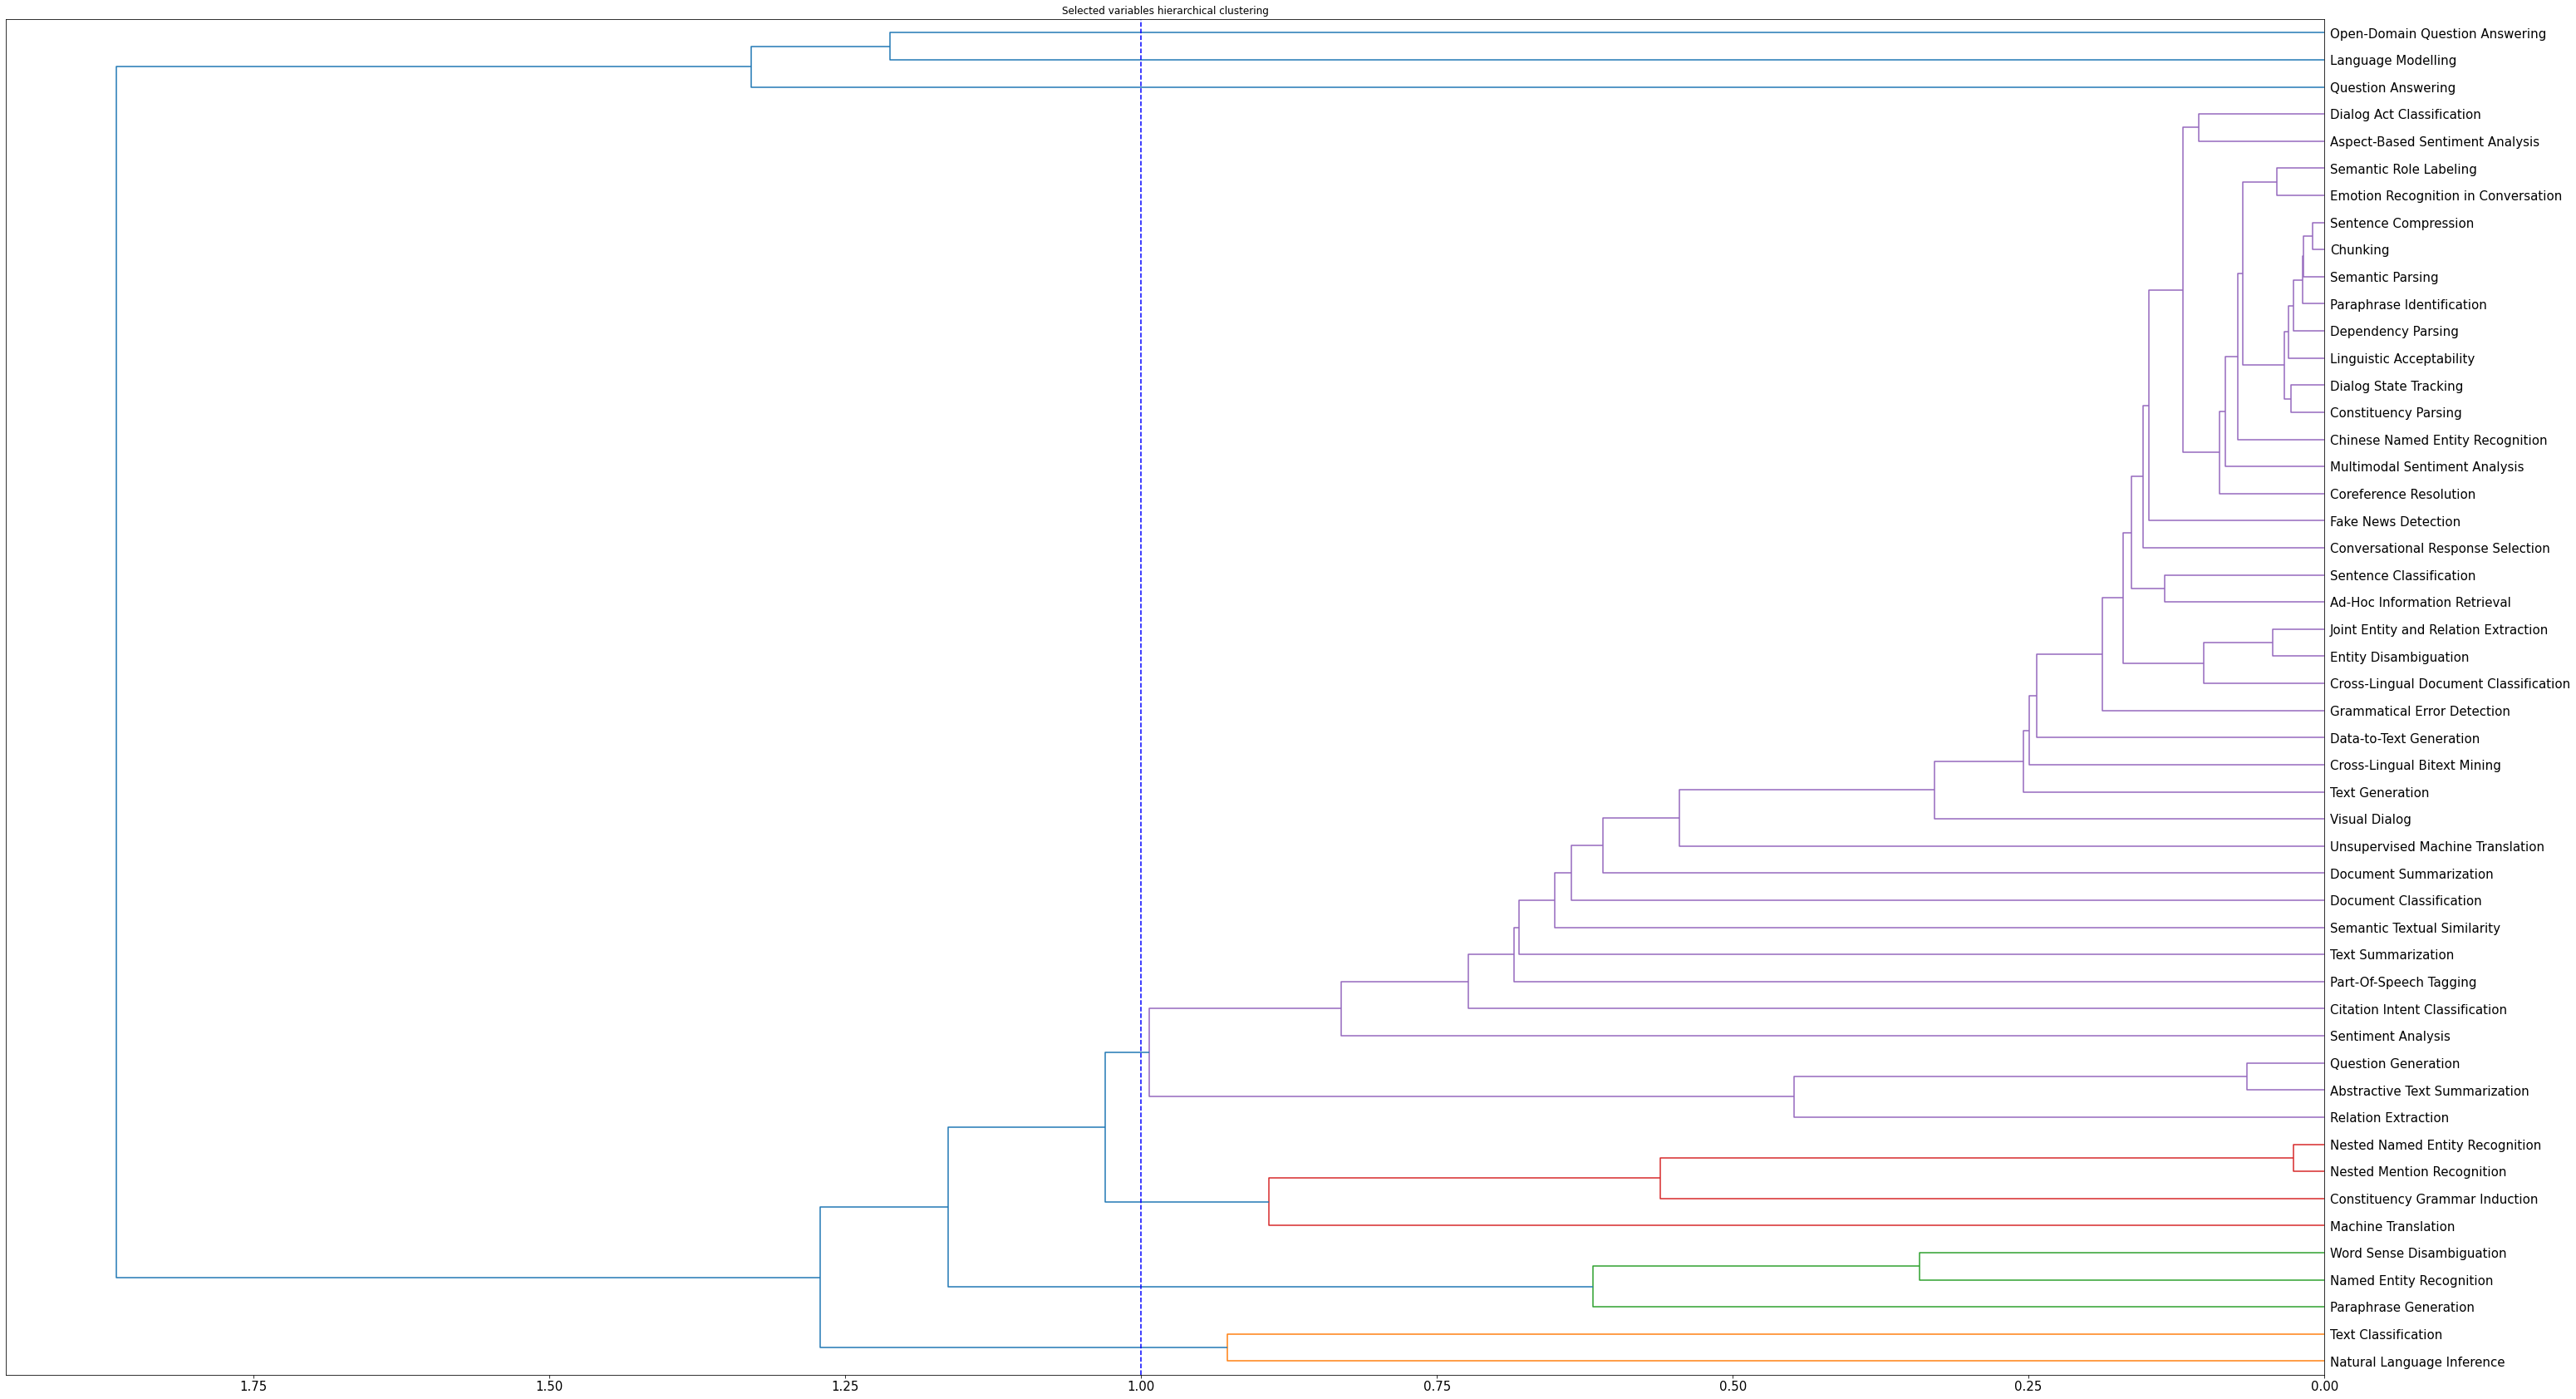

In [18]:
import scipy.cluster.hierarchy as shc

# col_filter="Accuracy,"
# col_filter="F1,|Accuracy,|BLEU,|Recall,|Precision,|BLEU score,"

plt.figure(figsize=(50, 30))
plt.title("Selected variables hierarchical clustering")

# cut=400 #for value

cut = 1  # for percentage

# define inside the regular expression which variable to use for the clustering (unique_vars variable)
dend = shc.dendrogram(
    shc.linkage(np.array(input_hc), method="ward"),
    labels=df.index,
    orientation="left",
    color_threshold=cut,
)
ax = plt.gca()
ax.tick_params(axis="x", which="major", labelsize=15)
ax.tick_params(axis="y", which="major", labelsize=15)
plt.axvline(linestyle="--", x=cut, c="Blue")

# plt.savefig('dend_percent_max_sota.png')
# plt.savefig('dend_percent.png')
# plt.savefig('dend_value.png')
plt.savefig("./PLOT_4_plots/dend_ratio_unique_task.png")


# Ref:https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [19]:
input_hc

2019-05  2019-12  2020-01  2018-09  2018-10  \
task                                                                            
Abstractive Text Summarization       0.40     0.03     0.01    0.000    0.000   
Ad-Hoc Information Retrieval         0.00     0.00     0.00    0.001    0.001   
Aspect-Based Sentiment Analysis      0.00     0.02     0.00    0.000    0.020   
Chinese Named Entity Recognition     0.00     0.00     0.00    0.000    0.000   
Chunking                             0.00     0.00     0.00    0.000    0.000   
...                                   ...      ...      ...      ...      ...   
Text Generation                      0.00     0.00     0.00    0.000    0.000   
Text Summarization                   0.02     0.01     0.01    0.000    0.000   
Unsupervised Machine Translation     0.04     0.00     0.00    0.000    0.040   
Visual Dialog                        0.00     0.00     0.00    0.000    0.000   
Word Sense Disambiguation            0.08     0.00     0.00    0.000    0.000   

                                  2018-12  2019-03  2019-04  2016-05  2017-09  \
task                                                                            
Abstractive Text Summarization      0.000    0.000     0.00     0.00     0.00   
Ad-Hoc Information Retrieval        0.001    0.001     0.10     0.00     0.00   
Aspect-Based Sentiment Analysis     0.000    0.000     0.01     0.05     0.02   
Chinese Named Entity Recognition    0.000    0.000     0.00     0.00     0.00   
Chunking                            0.000    0.000     0.00     0.00     0.00   
...                                   ...      ...      ...      ...      ...   
Text Generation                     0.000    0.000     0.00     0.00     0.18   
Text Summarization                  0.000    0.000     0.04     0.00     0.02   
Unsupervised Machine Translation    0.000    0.000     0.00     0.00     0.00   
Visual Dialog                       0.000    0.000     0.06     0.00     0.00   
Word Sense Disambiguation           0.000    0.000     0.00     0.00     0.00   

                                  2018-02  2018-04  2018-05  2018-06  2019-02  \
task                                                                            
Abstractive Text Summarization       0.00     0.00     0.00     0.00     0.00   
Ad-Hoc Information Retrieval         0.00     0.00     0.00     0.00     0.00   
Aspect-Based Sentiment Analysis      0.01     0.04     0.01     0.01     0.02   
Chinese Named Entity Recognition     0.00     0.00     0.00     0.00     0.00   
Chunking                             0.00     0.00     0.00     0.00     0.00   
...                                   ...      ...      ...      ...      ...   
Text Generation                      0.00     0.00     0.00     0.00     0.00   
Text Summarization                   0.00     0.00     0.00     0.02     0.00   
Unsupervised Machine Translation     0.00     0.00     0.00     0.00     0.10   
Visual Dialog                        0.00     0.00     0.00     0.00     0.23   
Word Sense Disambiguation            0.00     0.00     0.00     0.42     0.00   

                                  2019-06  2019-08  2020-04  2019-07  2019-10  \
task                                                                            
Abstractive Text Summarization       0.00     0.00     0.00     0.00     0.00   
Ad-Hoc Information Retrieval         0.00     0.00     0.00     0.00     0.00   
Aspect-Based Sentiment Analysis      0.01     0.03     0.01     0.00     0.00   
Chinese Named Entity Recognition     0.00     0.00     0.00     0.01     0.05   
Chunking                             0.00     0.00     0.00     0.00     0.00   
...                                   ...      ...      ...      ...      ...   
Text Generation                      0.00     0.00     0.00     0.00     0.00   
Text Summarization                   0.00     0.00     0.00     0.00     0.00   
Unsupervised Machine Translation     0.00     0.00     0.00   

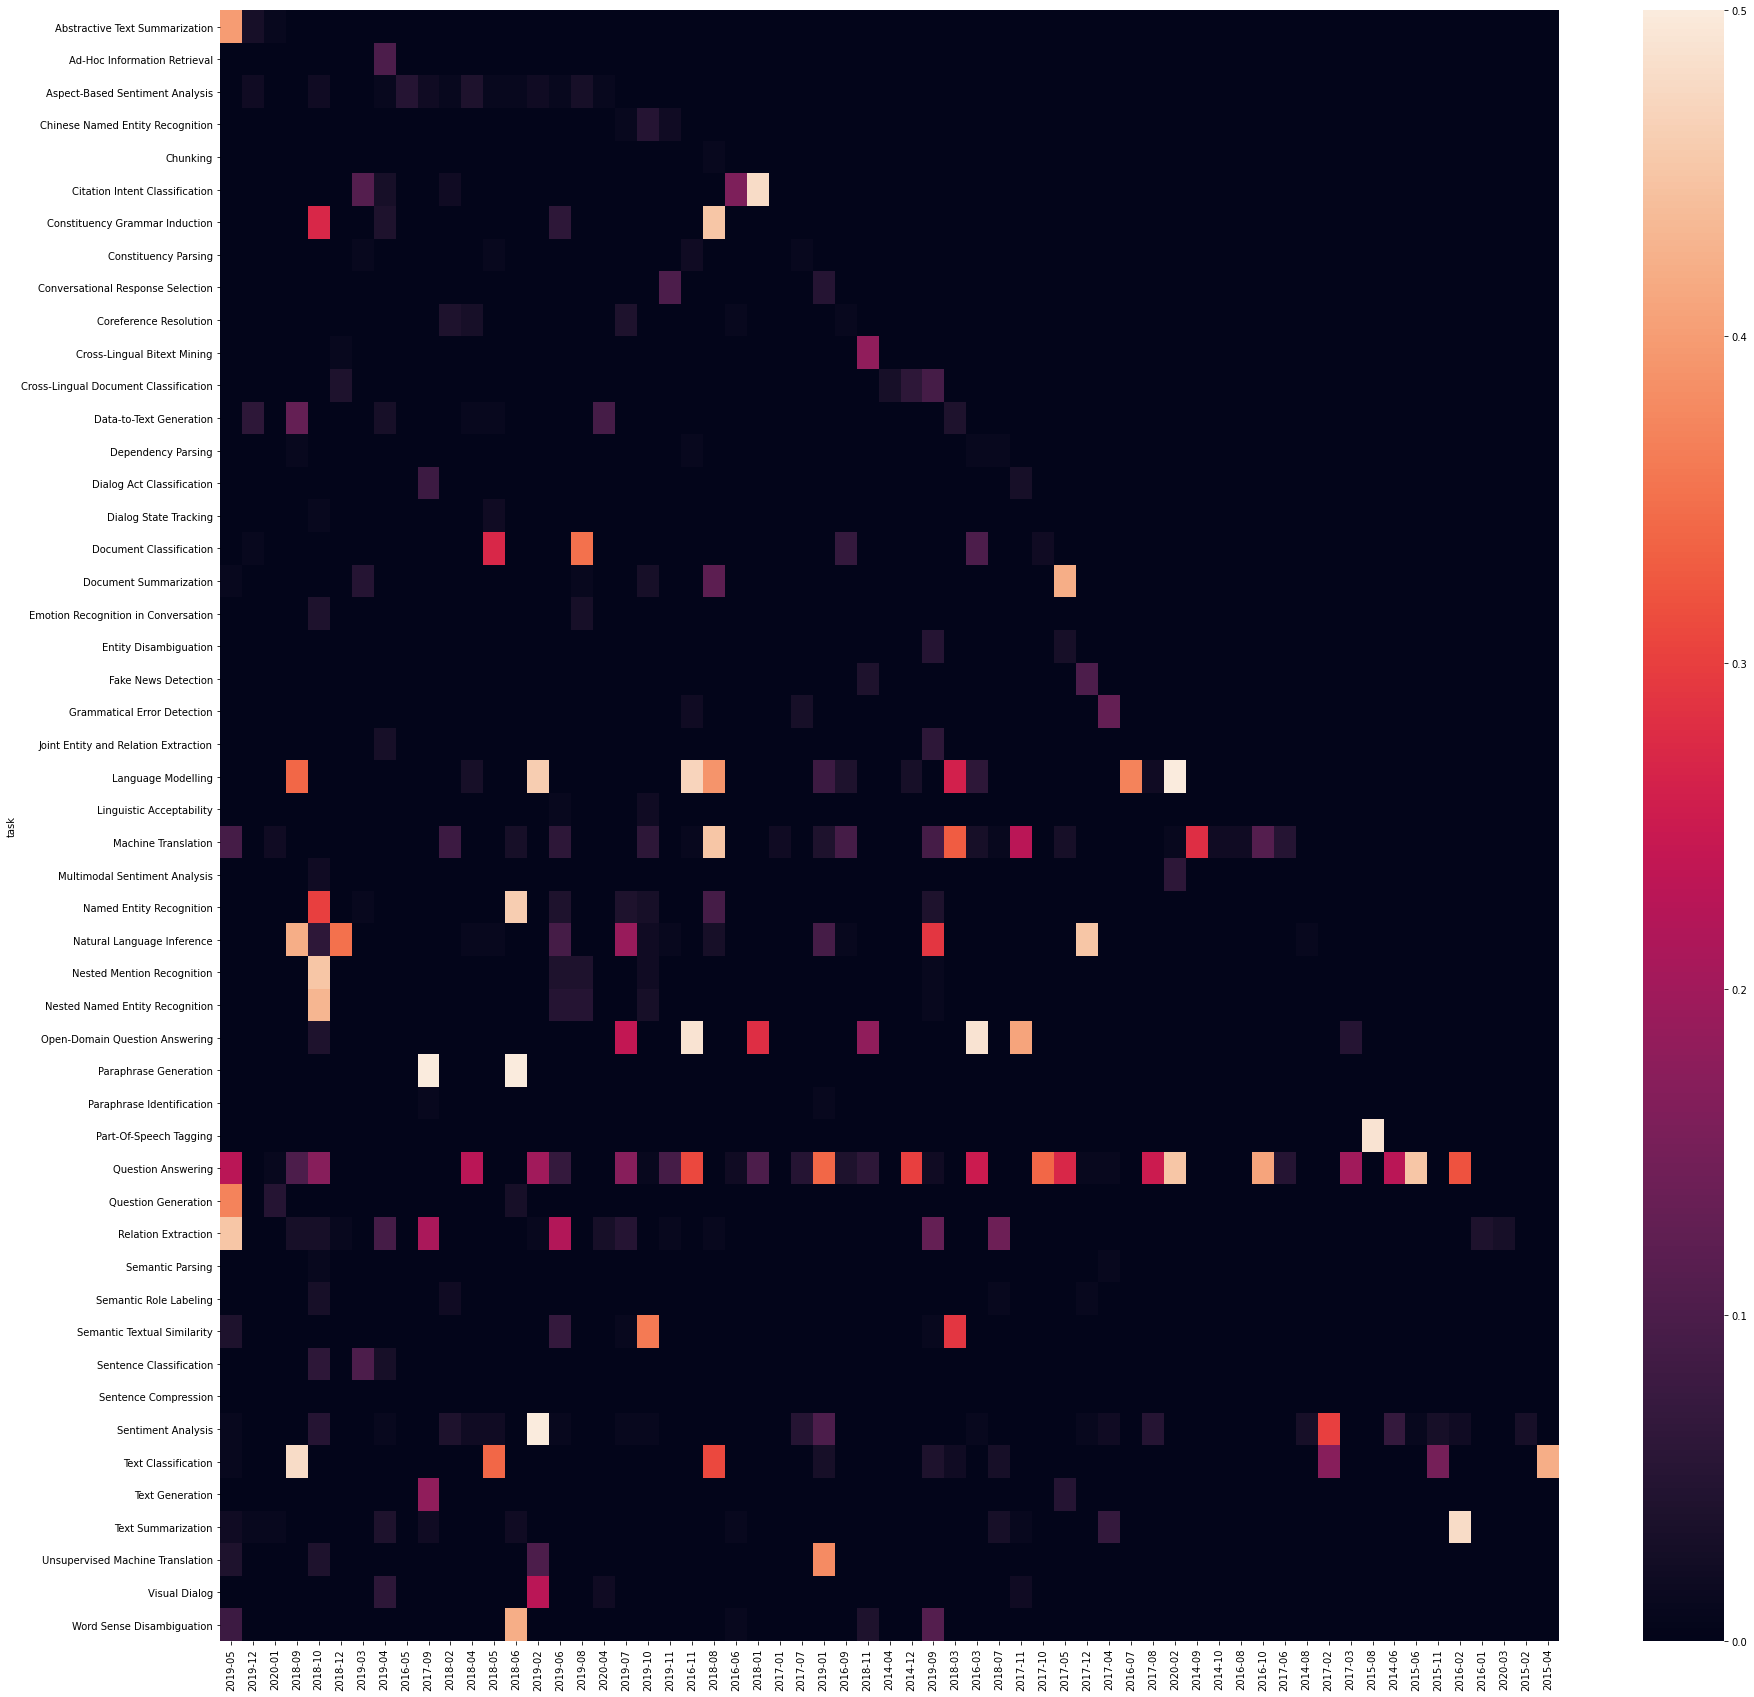

In [20]:
# plot heatmap (better to use clustermap below)
fig, ax = plt.subplots(figsize=(30, 30))
ax = sns.heatmap(input_hc)
plt.savefig("./PLOT_4_plots/heat_task.png")
# Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html

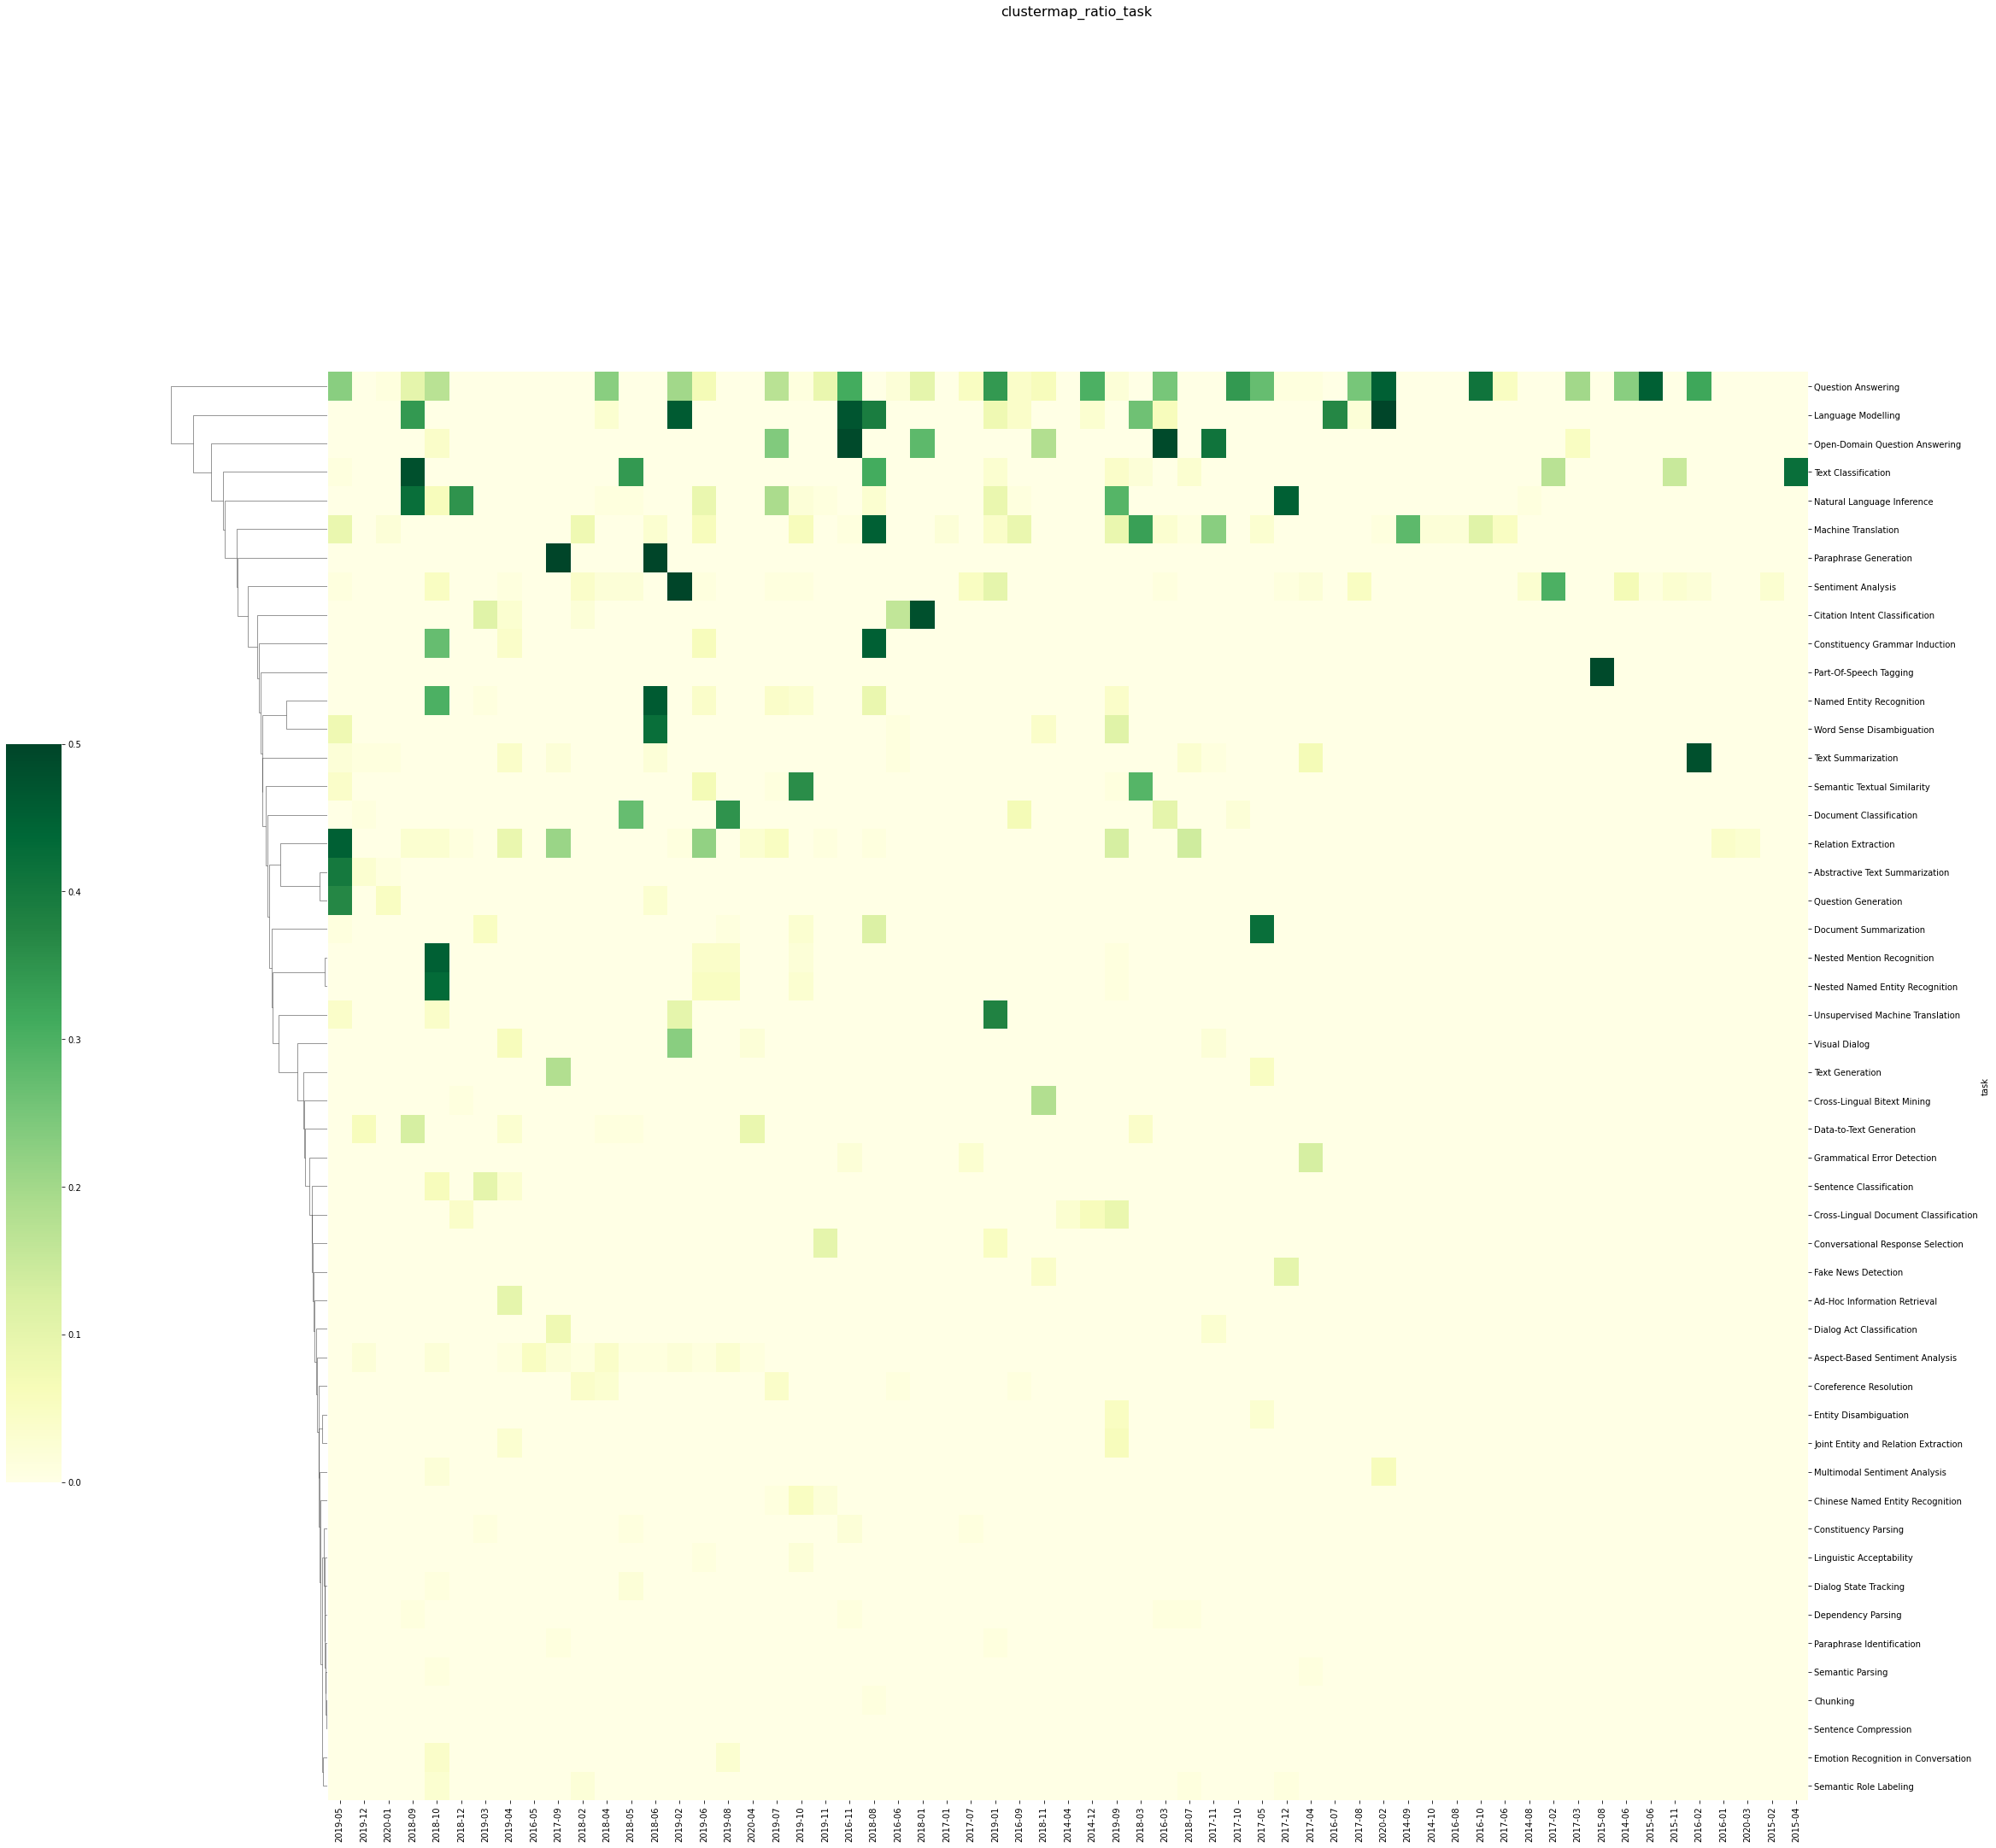

In [21]:
# clustermap showing distance analysis between the tasks
df = df.sort_index(axis=1) # this sorts the columns of the df (dates)
res = sns.clustermap(
    input_hc,
    figsize=(30, 30),
    metric="euclidean",
    cmap="YlGn",
    # row_cluster=False,
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.2),
    cbar_pos=(-0.08, 0.2, 0.03, 0.4),
)
# plt.subplots_adjust(top=0.9)
plt.suptitle("clustermap_ratio_task", y=1, fontsize=16)
plt.savefig("./PLOT_4_plots/clustermap_ratio_task.png")
# Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html

## Extract the reordered table

In [22]:
# ref
# https://github.com/Stemanz/python_tutorials/blob/master/seaborn/extract_ordered_table_from_heatmap/Retrieve%20ordered%20table%20from%20clustermap.ipynb


def extract_clustered_table(res, data):
    """
    input
    =====
    res:     <sns.matrix.ClusterGrid>  the clustermap object
    data:    <pd.DataFrame>            input table

    output
    ======
    returns: <pd.DataFrame>            reordered input table
    """

    # if sns.clustermap is run with row_cluster=False:
    if res.dendrogram_row is None:
        print("Apparently, rows were not clustered.")
        return -1

    if res.dendrogram_col is not None:
        # reordering index and columns
        new_cols = data.columns[res.dendrogram_col.reordered_ind]
        new_ind = data.index[res.dendrogram_row.reordered_ind]

        return data.loc[new_ind, new_cols]

    else:
        # reordering the index
        new_ind = data.index[res.dendrogram_row.reordered_ind]

        return data.loc[new_ind, :]

In [23]:
#extract the clustered table order
reordered_df = extract_clustered_table(res, df)

In [24]:
#check the number of tasks
len(reordered_df.index.values)

50

In [25]:
#list the tasks
reordered_df.index.values

array(['Question Answering', 'Language Modelling',
       'Open-Domain Question Answering', 'Text Classification',
       'Natural Language Inference', 'Machine Translation',
       'Paraphrase Generation', 'Sentiment Analysis',
       'Citation Intent Classification', 'Constituency Grammar Induction',
       'Part-Of-Speech Tagging', 'Named Entity Recognition',
       'Word Sense Disambiguation', 'Text Summarization',
       'Semantic Textual Similarity', 'Document Classification',
       'Relation Extraction', 'Abstractive Text Summarization',
       'Question Generation', 'Document Summarization',
       'Nested Mention Recognition', 'Nested Named Entity Recognition',
       'Unsupervised Machine Translation', 'Visual Dialog',
       'Text Generation', 'Cross-Lingual Bitext Mining',
       'Data-to-Text Generation', 'Grammatical Error Detection',
       'Sentence Classification', 'Cross-Lingual Document Classification',
       'Conversational Response Selection', 'Fake News Detectio

In [26]:
average_summary_IN.columns

Index(['task', 'date', 'ratio', 'in_trajectory'], dtype='object')

In [27]:
#create a reordered copy of the average df
average_summary_IN2 = pd.DataFrame(columns=average_summary_IN.columns)
#average_summary_IN2

for task in reordered_df.index.values:
    row = average_summary_IN[average_summary_IN.task == task]
    average_summary_IN2 = average_summary_IN2.append(row, ignore_index=True)
#    average_summary_IN2 = average_summary_IN2.append(row)

#this has now the same order of the clustered results
average_summary_IN2

task     date  ratio in_trajectory
0                     Question Answering  2014-06  0.230            IN
1                     Question Answering  2014-12  0.300            IN
2                     Question Answering  2015-06  0.450            IN
3                     Question Answering  2015-11  0.001            IN
4                     Question Answering  2016-02  0.320            IN
..                                   ...      ...    ...           ...
325  Emotion Recognition in Conversation  2019-08  0.030            IN
326               Semantic Role Labeling  2017-12  0.010            IN
327               Semantic Role Labeling  2018-02  0.020            IN
328               Semantic Role Labeling  2018-07  0.010            IN
329               Semantic Role Labeling  2018-10  0.030            IN

[330 rows x 4 columns]

In [28]:
fig_traj = px.line(average_summary_IN2, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

# This adds/remove those points with value < 1 and > 0.5
#add_white("task")

fig_traj.add_trace(
    go.Scatter(
        x=average_summary_IN2["date"],
        y=average_summary_IN2["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN2["task"]
        + "<BR>task: "
        + average_summary_IN2["task"]
        + "<BR>date: "
        + average_summary_IN2["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN2["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN2["ratio"],  # set color equal to a variable
            colorscale="YlGn",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig_traj.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig_traj.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig_traj.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig_traj.update_layout(
    title="Trajectory for ratio (task per year)",
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)

fig_traj.show()

import plotly.io as pio
# save trajectory plot to file
pio.write_image(fig_traj, "./PLOT_4_plots/fig_traj.png")

### Use the proportionalized average_summary

In [29]:
#make sure all ratio have a non-zero value.
average_summary_IN2[average_summary_IN2.ratio==0]

Empty DataFrame
Columns: [task, date, ratio, in_trajectory]
Index: []

In [41]:
#create average_summary_IN2_SUM, with the sum of ratios per taks
average_summary_IN2_SUM = pd.DataFrame(average_summary_IN2.groupby(['task']).sum())
#move index to column
average_summary_IN2_SUM = average_summary_IN2_SUM.reset_index(level='task')

#average_summary_IN_SUM[average_summary_IN_SUM.task=="Chunking"].ratio.iloc[0]

#copy the proportionalized data frame
average_summary_IN2_prop = average_summary_IN2.copy()
average_summary_IN2_prop.reset_index()

#iterate the average_summary_IN_prop and change the values accordingly
for i in average_summary_IN2_prop.index.values:
    average_summary_IN2_prop.loc[i,"ratio"] = round(average_summary_IN2_prop.loc[i,"ratio"] / average_summary_IN2_SUM[average_summary_IN2_SUM.task==average_summary_IN2_prop.loc[i,"task"]].ratio.iloc[0],4)

#this is the proportionalized df
average_summary_IN2_prop

task     date   ratio in_trajectory
0                     Question Answering  2014-06  0.0399            IN
1                     Question Answering  2014-12  0.0521            IN
2                     Question Answering  2015-06  0.0781            IN
3                     Question Answering  2015-11  0.0002            IN
4                     Question Answering  2016-02  0.0555            IN
..                                   ...      ...     ...           ...
325  Emotion Recognition in Conversation  2019-08  0.4167            IN
326               Semantic Role Labeling  2017-12  0.1429            IN
327               Semantic Role Labeling  2018-02  0.2857            IN
328               Semantic Role Labeling  2018-07  0.1429            IN
329               Semantic Role Labeling  2018-10  0.4286            IN

[330 rows x 4 columns]

In [42]:
#Compare raw values...
average_summary_IN2[average_summary_IN2.task=="Question Answering"]

task     date  ratio in_trajectory
0   Question Answering  2014-06  0.230            IN
1   Question Answering  2014-12  0.300            IN
2   Question Answering  2015-06  0.450            IN
3   Question Answering  2015-11  0.001            IN
4   Question Answering  2016-02  0.320            IN
..                 ...      ...    ...           ...
29  Question Answering  2019-09  0.020            IN
30  Question Answering  2019-10  0.010            IN
31  Question Answering  2019-11  0.090            IN
32  Question Answering  2020-01  0.010            IN
33  Question Answering  2020-02  0.450            IN

[34 rows x 4 columns]

In [43]:
#...with normalized values.
average_summary_IN3 = average_summary_IN2_prop.copy()

average_summary_IN3[average_summary_IN3.task=="Question Answering"]

task     date   ratio in_trajectory
0   Question Answering  2014-06  0.0399            IN
1   Question Answering  2014-12  0.0521            IN
2   Question Answering  2015-06  0.0781            IN
3   Question Answering  2015-11  0.0002            IN
4   Question Answering  2016-02  0.0555            IN
..                 ...      ...     ...           ...
29  Question Answering  2019-09  0.0035            IN
30  Question Answering  2019-10  0.0017            IN
31  Question Answering  2019-11  0.0156            IN
32  Question Answering  2020-01  0.0017            IN
33  Question Answering  2020-02  0.0781            IN

[34 rows x 4 columns]

In [44]:
#plot now the trajectory using the normalized values

In [45]:
fig_traj_norm = px.line(average_summary_IN3, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

# This adds/remove those points with value < 1 and > 0.5
#add_white("task")

fig_traj_norm.add_trace(
    go.Scatter(
        x=average_summary_IN3["date"],
        y=average_summary_IN3["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN3["task"]
        + "<BR>task: "
        + average_summary_IN3["task"]
        + "<BR>date: "
        + average_summary_IN3["date"].astype("string")
        + "<BR>ratio: "
        + average_summary_IN3["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN3["ratio"],  # set color equal to a variable
            colorscale="YlGn",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig_traj_norm.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig_traj_norm.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig_traj_norm.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig_traj_norm.update_layout(
    title="Trajectory for ratio (task per year) - Normalized",
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)

fig_traj_norm.show()

import plotly.io as pio
# save trajectory plot to file
pio.write_image(fig_traj_norm, "./PLOT_4_plots/fig_traj_norm.png")

In [46]:
#Prepare and run HC for the Normalized average_summary_IN3 df

df_melted = pd.melt(average_summary_IN3, id_vars=["task", "date"], value_vars=["ratio"])

df_melted["value"].astype(float)

#this sets the DS as leaves for the  clustering entities
df=pd.DataFrame(columns=df_melted["date"].unique())

df["task"]=df_melted["task"].unique()

df=df.set_index("task")

for ds in df_melted["task"].unique():
    for var in df_melted["date"].unique():
    #print(ds)
        value = df_melted[(df_melted["task"]==ds)&(df_melted["date"]==var)]["value"]
        if(len(value)>0):
            print(ds,"\t",var,"\t",value.iloc[0])
            df.loc[ds,var] = value.iloc[0]
            #df = df.append(pd.Series({var: value}, name=ds))
        else:
            print(ds,"\t",var,"\t0",)
            #df(ds)[var] = "NaN"
            #df = df.append(pd.Series({var: "NaN"}, name=ds))   
df = df.fillna(0)

report = pd.DataFrame(df.describe().T)
report = report.sort_values(by="count", ascending=False)

#get here the top (unique>10) variables to use for the HC 
#Obs: in this case if we use the task as clustering entities, then it doesn't make sense to filter. Just use every thing
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)

report = pd.DataFrame(df.describe().T)

report=report.sort_values(by='count', ascending=False)

#select variables that have been colected at least by 10 benchmarks
#when using tasks for clustering, keep it >0
unique_vars = list(report[report["count"]>0].index.unique())

#col_filter
#df.filter(regex=col_filter)

input_hc = df[df.columns.intersection(unique_vars)]


Question Answering 	 2014-06 	 0.0399
Question Answering 	 2014-12 	 0.0521
Question Answering 	 2015-06 	 0.0781
Question Answering 	 2015-11 	 0.0002
Question Answering 	 2016-02 	 0.0555
Question Answering 	 2016-03 	 0.0434
Question Answering 	 2016-06 	 0.0035
Question Answering 	 2016-09 	 0.0069
Question Answering 	 2016-10 	 0.0712
Question Answering 	 2016-11 	 0.0538
Question Answering 	 2017-03 	 0.0347
Question Answering 	 2017-04 	 0.0017
Question Answering 	 2017-05 	 0.0469
Question Answering 	 2017-06 	 0.0087
Question Answering 	 2017-07 	 0.0087
Question Answering 	 2017-08 	 0.0434
Question Answering 	 2017-10 	 0.059
Question Answering 	 2017-12 	 0.0017
Question Answering 	 2018-01 	 0.0174
Question Answering 	 2018-04 	 0.0399
Question Answering 	 2018-09 	 0.0174
Question Answering 	 2018-10 	 0.0295
Question Answering 	 2018-11 	 0.0104
Question Answering 	 2019-01 	 0.059
Question Answering 	 2019-02 	 0.0347
Question Answering 	 2019-05 	 0.0399
Question Answe

Natural Language Inference 	 2019-07 	 0.093
Natural Language Inference 	 2019-08 	0
Natural Language Inference 	 2019-09 	 0.1419
Natural Language Inference 	 2019-10 	 0.0098
Natural Language Inference 	 2019-11 	 0.0049
Natural Language Inference 	 2020-01 	0
Natural Language Inference 	 2020-02 	0
Natural Language Inference 	 2016-07 	0
Natural Language Inference 	 2017-11 	 0.0005
Natural Language Inference 	 2018-03 	0
Natural Language Inference 	 2018-08 	 0.0147
Natural Language Inference 	 2015-04 	0
Natural Language Inference 	 2017-02 	 0.0005
Natural Language Inference 	 2018-05 	 0.0049
Natural Language Inference 	 2018-07 	0
Natural Language Inference 	 2014-08 	 0.0049
Natural Language Inference 	 2017-09 	 0.0005
Natural Language Inference 	 2018-12 	 0.1712
Natural Language Inference 	 2014-09 	0
Natural Language Inference 	 2014-10 	0
Natural Language Inference 	 2016-08 	0
Natural Language Inference 	 2017-01 	0
Natural Language Inference 	 2018-02 	0
Natural Languag

Citation Intent Classification 	 2016-11 	0
Citation Intent Classification 	 2017-03 	0
Citation Intent Classification 	 2017-04 	0
Citation Intent Classification 	 2017-05 	0
Citation Intent Classification 	 2017-06 	0
Citation Intent Classification 	 2017-07 	0
Citation Intent Classification 	 2017-08 	0
Citation Intent Classification 	 2017-10 	0
Citation Intent Classification 	 2017-12 	0
Citation Intent Classification 	 2018-01 	 0.6
Citation Intent Classification 	 2018-04 	0
Citation Intent Classification 	 2018-09 	0
Citation Intent Classification 	 2018-10 	0
Citation Intent Classification 	 2018-11 	0
Citation Intent Classification 	 2019-01 	0
Citation Intent Classification 	 2019-02 	0
Citation Intent Classification 	 2019-05 	0
Citation Intent Classification 	 2019-06 	0
Citation Intent Classification 	 2019-07 	0
Citation Intent Classification 	 2019-08 	0
Citation Intent Classification 	 2019-09 	0
Citation Intent Classification 	 2019-10 	0
Citation Intent Classificatio

Word Sense Disambiguation 	 2016-02 	0
Word Sense Disambiguation 	 2016-03 	0
Word Sense Disambiguation 	 2016-06 	 0.0151
Word Sense Disambiguation 	 2016-09 	0
Word Sense Disambiguation 	 2016-10 	0
Word Sense Disambiguation 	 2016-11 	0
Word Sense Disambiguation 	 2017-03 	0
Word Sense Disambiguation 	 2017-04 	0
Word Sense Disambiguation 	 2017-05 	0
Word Sense Disambiguation 	 2017-06 	0
Word Sense Disambiguation 	 2017-07 	0
Word Sense Disambiguation 	 2017-08 	0
Word Sense Disambiguation 	 2017-10 	0
Word Sense Disambiguation 	 2017-12 	0
Word Sense Disambiguation 	 2018-01 	0
Word Sense Disambiguation 	 2018-04 	0
Word Sense Disambiguation 	 2018-09 	0
Word Sense Disambiguation 	 2018-10 	0
Word Sense Disambiguation 	 2018-11 	 0.0605
Word Sense Disambiguation 	 2019-01 	0
Word Sense Disambiguation 	 2019-02 	0
Word Sense Disambiguation 	 2019-05 	 0.121
Word Sense Disambiguation 	 2019-06 	0
Word Sense Disambiguation 	 2019-07 	0
Word Sense Disambiguation 	 2019-08 	0
Word Sen

Relation Extraction 	 2016-10 	0
Relation Extraction 	 2016-11 	0
Relation Extraction 	 2017-03 	0
Relation Extraction 	 2017-04 	0
Relation Extraction 	 2017-05 	0
Relation Extraction 	 2017-06 	0
Relation Extraction 	 2017-07 	 0.0007
Relation Extraction 	 2017-08 	0
Relation Extraction 	 2017-10 	0
Relation Extraction 	 2017-12 	0
Relation Extraction 	 2018-01 	0
Relation Extraction 	 2018-04 	0
Relation Extraction 	 2018-09 	 0.0201
Relation Extraction 	 2018-10 	 0.0201
Relation Extraction 	 2018-11 	0
Relation Extraction 	 2019-01 	0
Relation Extraction 	 2019-02 	 0.0067
Relation Extraction 	 2019-05 	 0.3018
Relation Extraction 	 2019-06 	 0.1476
Relation Extraction 	 2019-07 	 0.0335
Relation Extraction 	 2019-08 	0
Relation Extraction 	 2019-09 	 0.0872
Relation Extraction 	 2019-10 	0
Relation Extraction 	 2019-11 	 0.0067
Relation Extraction 	 2020-01 	0
Relation Extraction 	 2020-02 	0
Relation Extraction 	 2016-07 	0
Relation Extraction 	 2017-11 	0
Relation Extraction 	 

Document Summarization 	 2019-12 	0
Document Summarization 	 2016-01 	0
Document Summarization 	 2020-03 	0
Document Summarization 	 2020-04 	0
Document Summarization 	 2014-04 	0
Document Summarization 	 2016-05 	0
Nested Mention Recognition 	 2014-06 	0
Nested Mention Recognition 	 2014-12 	0
Nested Mention Recognition 	 2015-06 	0
Nested Mention Recognition 	 2015-11 	0
Nested Mention Recognition 	 2016-02 	0
Nested Mention Recognition 	 2016-03 	0
Nested Mention Recognition 	 2016-06 	0
Nested Mention Recognition 	 2016-09 	0
Nested Mention Recognition 	 2016-10 	0
Nested Mention Recognition 	 2016-11 	0
Nested Mention Recognition 	 2017-03 	0
Nested Mention Recognition 	 2017-04 	0
Nested Mention Recognition 	 2017-05 	0
Nested Mention Recognition 	 2017-06 	0
Nested Mention Recognition 	 2017-07 	0
Nested Mention Recognition 	 2017-08 	0
Nested Mention Recognition 	 2017-10 	0
Nested Mention Recognition 	 2017-12 	0
Nested Mention Recognition 	 2018-01 	0
Nested Mention Recogniti

Visual Dialog 	 2018-10 	0
Visual Dialog 	 2018-11 	0
Visual Dialog 	 2019-01 	0
Visual Dialog 	 2019-02 	 0.697
Visual Dialog 	 2019-05 	0
Visual Dialog 	 2019-06 	0
Visual Dialog 	 2019-07 	0
Visual Dialog 	 2019-08 	0
Visual Dialog 	 2019-09 	0
Visual Dialog 	 2019-10 	0
Visual Dialog 	 2019-11 	0
Visual Dialog 	 2020-01 	0
Visual Dialog 	 2020-02 	0
Visual Dialog 	 2016-07 	0
Visual Dialog 	 2017-11 	 0.0606
Visual Dialog 	 2018-03 	0
Visual Dialog 	 2018-08 	0
Visual Dialog 	 2015-04 	0
Visual Dialog 	 2017-02 	0
Visual Dialog 	 2018-05 	0
Visual Dialog 	 2018-07 	0
Visual Dialog 	 2014-08 	0
Visual Dialog 	 2017-09 	0
Visual Dialog 	 2018-12 	0
Visual Dialog 	 2014-09 	0
Visual Dialog 	 2014-10 	0
Visual Dialog 	 2016-08 	0
Visual Dialog 	 2017-01 	0
Visual Dialog 	 2018-02 	0
Visual Dialog 	 2018-06 	0
Visual Dialog 	 2015-02 	0
Visual Dialog 	 2019-04 	 0.1818
Visual Dialog 	 2019-03 	0
Visual Dialog 	 2015-08 	0
Visual Dialog 	 2019-12 	0
Visual Dialog 	 2016-01 	0
Visual Dial

Sentence Classification 	 2016-06 	0
Sentence Classification 	 2016-09 	0
Sentence Classification 	 2016-10 	0
Sentence Classification 	 2016-11 	0
Sentence Classification 	 2017-03 	0
Sentence Classification 	 2017-04 	0
Sentence Classification 	 2017-05 	0
Sentence Classification 	 2017-06 	0
Sentence Classification 	 2017-07 	0
Sentence Classification 	 2017-08 	0
Sentence Classification 	 2017-10 	0
Sentence Classification 	 2017-12 	0
Sentence Classification 	 2018-01 	0
Sentence Classification 	 2018-04 	0
Sentence Classification 	 2018-09 	0
Sentence Classification 	 2018-10 	 0.3158
Sentence Classification 	 2018-11 	0
Sentence Classification 	 2019-01 	0
Sentence Classification 	 2019-02 	0
Sentence Classification 	 2019-05 	0
Sentence Classification 	 2019-06 	0
Sentence Classification 	 2019-07 	0
Sentence Classification 	 2019-08 	0
Sentence Classification 	 2019-09 	0
Sentence Classification 	 2019-10 	0
Sentence Classification 	 2019-11 	0
Sentence Classification 	 2020-0

Fake News Detection 	 2019-09 	0
Fake News Detection 	 2019-10 	0
Fake News Detection 	 2019-11 	0
Fake News Detection 	 2020-01 	0
Fake News Detection 	 2020-02 	0
Fake News Detection 	 2016-07 	0
Fake News Detection 	 2017-11 	0
Fake News Detection 	 2018-03 	0
Fake News Detection 	 2018-08 	0
Fake News Detection 	 2015-04 	0
Fake News Detection 	 2017-02 	0
Fake News Detection 	 2018-05 	0
Fake News Detection 	 2018-07 	0
Fake News Detection 	 2014-08 	0
Fake News Detection 	 2017-09 	0
Fake News Detection 	 2018-12 	0
Fake News Detection 	 2014-09 	0
Fake News Detection 	 2014-10 	0
Fake News Detection 	 2016-08 	0
Fake News Detection 	 2017-01 	0
Fake News Detection 	 2018-02 	0
Fake News Detection 	 2018-06 	0
Fake News Detection 	 2015-02 	0
Fake News Detection 	 2019-04 	0
Fake News Detection 	 2019-03 	0
Fake News Detection 	 2015-08 	0
Fake News Detection 	 2019-12 	0
Fake News Detection 	 2016-01 	0
Fake News Detection 	 2020-03 	0
Fake News Detection 	 2020-04 	0
Fake News 

Aspect-Based Sentiment Analysis 	 2014-04 	0
Aspect-Based Sentiment Analysis 	 2016-05 	 0.1923
Coreference Resolution 	 2014-06 	0
Coreference Resolution 	 2014-12 	0
Coreference Resolution 	 2015-06 	0
Coreference Resolution 	 2015-11 	0
Coreference Resolution 	 2016-02 	0
Coreference Resolution 	 2016-03 	0
Coreference Resolution 	 2016-06 	 0.0769
Coreference Resolution 	 2016-09 	 0.0769
Coreference Resolution 	 2016-10 	0
Coreference Resolution 	 2016-11 	0
Coreference Resolution 	 2017-03 	0
Coreference Resolution 	 2017-04 	0
Coreference Resolution 	 2017-05 	0
Coreference Resolution 	 2017-06 	0
Coreference Resolution 	 2017-07 	0
Coreference Resolution 	 2017-08 	0
Coreference Resolution 	 2017-10 	0
Coreference Resolution 	 2017-12 	0
Coreference Resolution 	 2018-01 	0
Coreference Resolution 	 2018-04 	 0.2308
Coreference Resolution 	 2018-09 	0
Coreference Resolution 	 2018-10 	0
Coreference Resolution 	 2018-11 	0
Coreference Resolution 	 2019-01 	0
Coreference Resolution

Multimodal Sentiment Analysis 	 2014-04 	0
Multimodal Sentiment Analysis 	 2016-05 	0
Chinese Named Entity Recognition 	 2014-06 	0
Chinese Named Entity Recognition 	 2014-12 	0
Chinese Named Entity Recognition 	 2015-06 	0
Chinese Named Entity Recognition 	 2015-11 	0
Chinese Named Entity Recognition 	 2016-02 	0
Chinese Named Entity Recognition 	 2016-03 	0
Chinese Named Entity Recognition 	 2016-06 	0
Chinese Named Entity Recognition 	 2016-09 	0
Chinese Named Entity Recognition 	 2016-10 	0
Chinese Named Entity Recognition 	 2016-11 	0
Chinese Named Entity Recognition 	 2017-03 	0
Chinese Named Entity Recognition 	 2017-04 	0
Chinese Named Entity Recognition 	 2017-05 	0
Chinese Named Entity Recognition 	 2017-06 	0
Chinese Named Entity Recognition 	 2017-07 	0
Chinese Named Entity Recognition 	 2017-08 	0
Chinese Named Entity Recognition 	 2017-10 	0
Chinese Named Entity Recognition 	 2017-12 	0
Chinese Named Entity Recognition 	 2018-01 	0
Chinese Named Entity Recognition 	 2018-

Dependency Parsing 	 2019-05 	0
Dependency Parsing 	 2019-06 	0
Dependency Parsing 	 2019-07 	0
Dependency Parsing 	 2019-08 	0
Dependency Parsing 	 2019-09 	0
Dependency Parsing 	 2019-10 	0
Dependency Parsing 	 2019-11 	0
Dependency Parsing 	 2020-01 	0
Dependency Parsing 	 2020-02 	0
Dependency Parsing 	 2016-07 	0
Dependency Parsing 	 2017-11 	0
Dependency Parsing 	 2018-03 	0
Dependency Parsing 	 2018-08 	0
Dependency Parsing 	 2015-04 	0
Dependency Parsing 	 2017-02 	0
Dependency Parsing 	 2018-05 	 0.0244
Dependency Parsing 	 2018-07 	 0.2439
Dependency Parsing 	 2014-08 	0
Dependency Parsing 	 2017-09 	0
Dependency Parsing 	 2018-12 	0
Dependency Parsing 	 2014-09 	0
Dependency Parsing 	 2014-10 	0
Dependency Parsing 	 2016-08 	0
Dependency Parsing 	 2017-01 	0
Dependency Parsing 	 2018-02 	0
Dependency Parsing 	 2018-06 	0
Dependency Parsing 	 2015-02 	0
Dependency Parsing 	 2019-04 	0
Dependency Parsing 	 2019-03 	0
Dependency Parsing 	 2015-08 	0
Dependency Parsing 	 2019-12

Emotion Recognition in Conversation 	 2018-01 	0
Emotion Recognition in Conversation 	 2018-04 	0
Emotion Recognition in Conversation 	 2018-09 	0
Emotion Recognition in Conversation 	 2018-10 	 0.5556
Emotion Recognition in Conversation 	 2018-11 	0
Emotion Recognition in Conversation 	 2019-01 	0
Emotion Recognition in Conversation 	 2019-02 	0
Emotion Recognition in Conversation 	 2019-05 	0
Emotion Recognition in Conversation 	 2019-06 	0
Emotion Recognition in Conversation 	 2019-07 	0
Emotion Recognition in Conversation 	 2019-08 	 0.4167
Emotion Recognition in Conversation 	 2019-09 	0
Emotion Recognition in Conversation 	 2019-10 	0
Emotion Recognition in Conversation 	 2019-11 	0
Emotion Recognition in Conversation 	 2020-01 	0
Emotion Recognition in Conversation 	 2020-02 	0
Emotion Recognition in Conversation 	 2016-07 	0
Emotion Recognition in Conversation 	 2017-11 	0
Emotion Recognition in Conversation 	 2018-03 	0
Emotion Recognition in Conversation 	 2018-08 	0
Emotion 

In [47]:
df.head(3)

2014-06  2014-12  2015-06  2015-11  2016-02  \
task                                                                          
Question Answering               0.0399   0.0521   0.0781   0.0002   0.0555   
Language Modelling               0.0000   0.0098   0.0000   0.0000   0.0000   
Open-Domain Question Answering   0.0000   0.0000   0.0000   0.0000   0.0000   

                                2016-03  2016-06  2016-09  2016-10  2016-11  \
task                                                                          
Question Answering               0.0434   0.0035   0.0069   0.0712   0.0538   
Language Modelling               0.0197   0.0000   0.0131   0.0000   0.1539   
Open-Domain Question Answering   0.2248   0.0000   0.0000   0.0000   0.2248   

                                2017-03  2017-04  2017-05  2017-06  2017-07  \
task                                                                          
Question Answering               0.0347   0.0017   0.0469   0.0087   0.0087   
Language Modelling               0.0000   0.0000   0.0003   0.0000   0.0000   
Open-Domain Question Answering   0.0229   0.0000   0.0000   0.0000   0.0000   

                                2017-08  2017-10  2017-12  2018-01  2018-04  \
task                                                                          
Question Answering               0.0434   0.0590   0.0017   0.0174   0.0399   
Language Modelling               0.0066   0.0003   0.0000   0.0000   0.0098   
Open-Domain Question Answering   0.0000   0.0000   0.0000   0.1284   0.0000   

                                2018-09  2018-10  2018-11  2019-01  2019-02  \
task                                                                          
Question Answering               0.0174   0.0295   0.0104   0.0590   0.0347   
Language Modelling               0.1114   0.0000   0.0000   0.0262   0.1507   
Open-Domain Question Answering   0.0000   0.0183   0.0826   0.0000   0.0000   

                                2019-05  2019-06  2019-07  2019-08  2019-09  \
task                                                                          
Question Answering               0.0399   0.0121   0.0295   0.0002   0.0035   
Language Modelling               0.0000   0.0000   0.0000   0.0000   0.0000   
Open-Domain Question Answering   0.0000   0.0000   0.1101   0.0000   0.0000   

                                2019-10  2019-11  2020-01  2020-02  2016-07  \
task                                                                          
Question Answering               0.0017   0.0156   0.0017   0.0781   0.0000   
Language Modelling               0.0000   0.0000   0.0000   0.1638   0.1212   
Open-Domain Question Answering   0.0000   0.0000   0.0000   0.0000   0.0000   

                                2017-11  2018-03  2018-08  2015-04  2017-02  \
task                                                                          
Question Answering               0.0000   0.0000   0.0000      0.0      0.0   
Language Modelling               0.0003   0.0852   0.1277      0.0      0.0   
Open-Domain Question Answering   0.1881   0.0000   0.0000      0.0      0.0   

                                2018-05  2018-07  2014-08  2017-09  2018-12  \
task                                                                          
Question Answering                  0.0      0.0      0.0      0.0      0.0   
Language Modelling                  0.0      0.0      0.0      0.0      0.0   
Open-Domain Question Answering      0.0      0.0      0.0      0.0      0.0   

                                2014-09  2014-10  2016-08  2017-01  2018-02  \
task                                                                          
Question Answering                  0.0      0.0      0.0      0.0      0.0   
Language Modelling                  0.0      0.0      0.0      0.0      0.0   
Open-Domain Question Answering      0.0      0.0      0.0      0.0      0.0   

                                2018-06  2015-02  2019-04  2019-03  2015

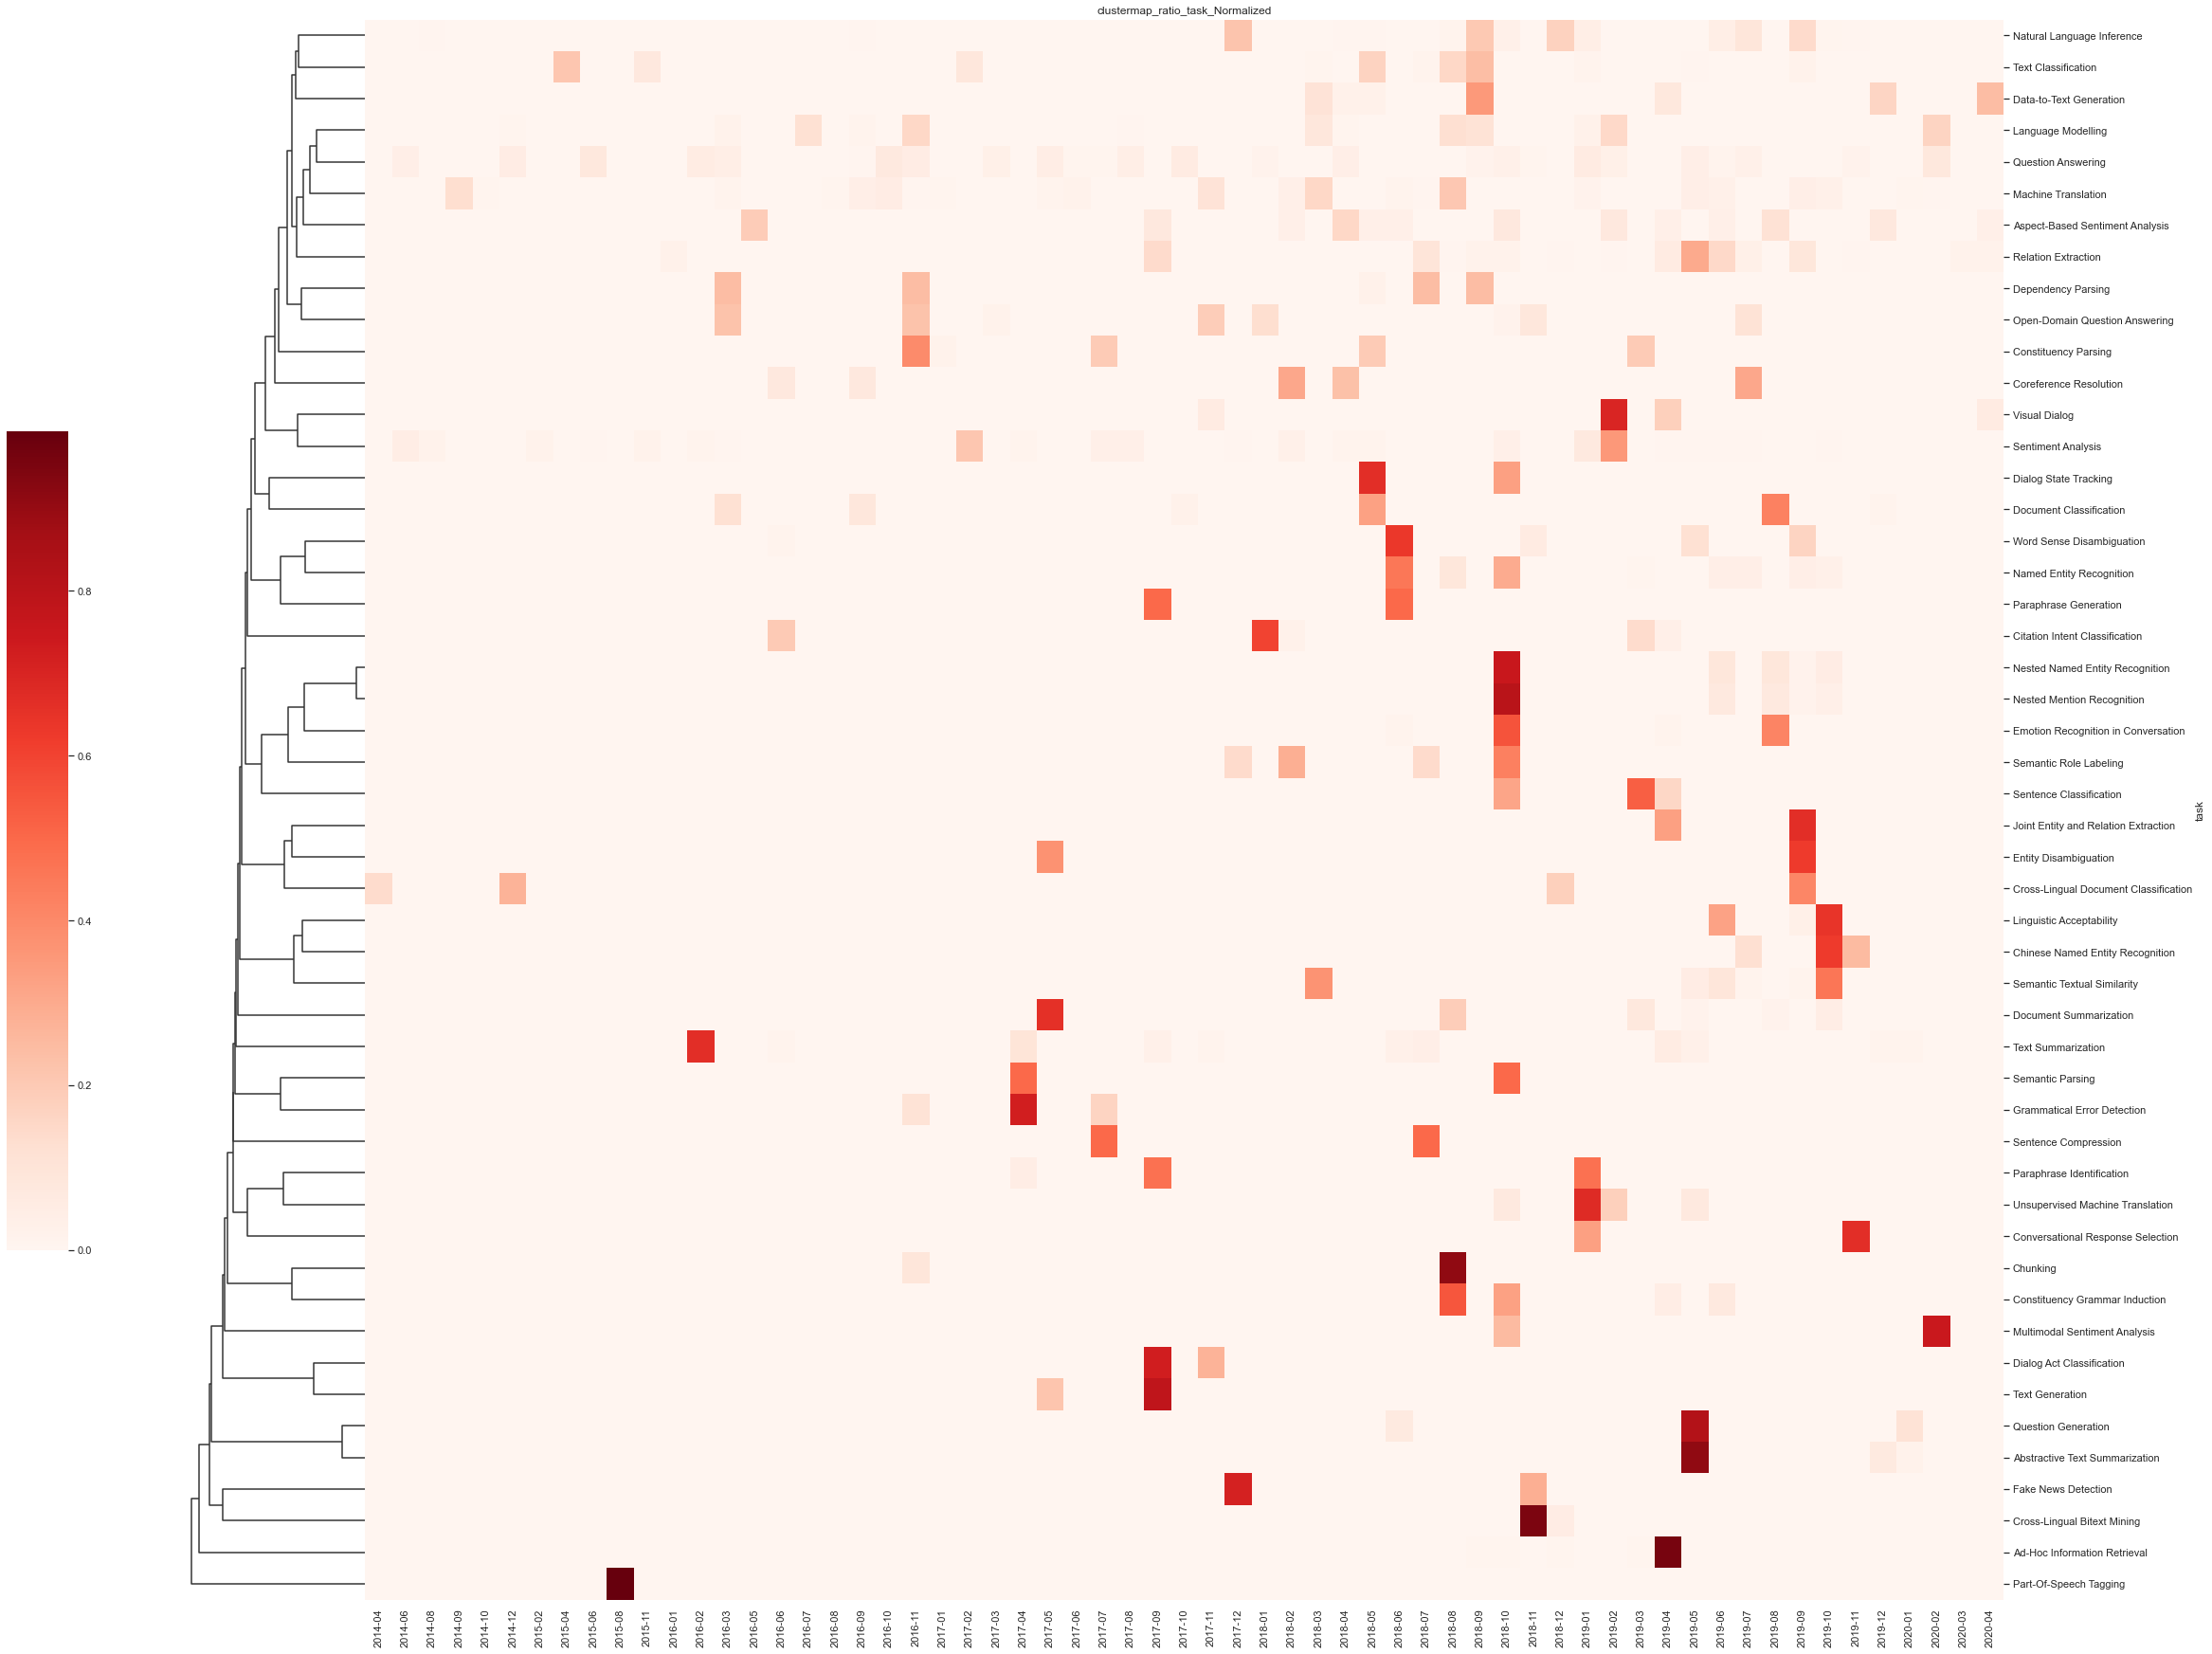

In [48]:
##Plot HC.
# Clustermap showing distance analysis between the tasks
# This plot uses the average of ratio normalized by the sum of all data points per task

df = df.sort_index(axis=1) # this sorts the columns of the df (dates)
sns.set(font_scale=1)
res2 = sns.clustermap(
    df,
    figsize=(30, 30),
    metric="euclidean",
    cmap="Reds",
    # row_cluster=False,
    col_cluster=False,
    dendrogram_ratio=(0.1, 0.2),
    cbar_pos=(-0.08, 0.2, 0.03, 0.4),
    tree_kws=dict(linewidths=1.5)
)
res2.ax_col_dendrogram.set_visible(False)

#reverse the y-axes of all the axes of the figure, we want to have the more particulated trajectories on the top.
res2.fig.axes[0].invert_yaxis()#tree
res2.fig.axes[1].invert_yaxis()
res2.fig.axes[2].invert_yaxis()#heat map and y-axis labels
#res2.fig.axes[3].invert_yaxis() #this is the color bar. No need to reorder

res2.ax_heatmap.set_title('clustermap_ratio_task_Normalized')
res2.savefig("./PLOT_4_plots/clustermap_ratio_task_Normalized.png")

# Ref:https://seaborn.pydata.org/generated/seaborn.clustermap.html

In [49]:
#figure axes
res2.fig.axes

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:title={'center':'clustermap_ratio_task_Normalized'}, ylabel='task'>,
 <AxesSubplot:>]

In [50]:
#reorder: extract the order of the clustered table
reordered_df2 = extract_clustered_table(res2, df)

#create copy and reorder
average_summary_IN4 = pd.DataFrame(columns=average_summary_IN3.columns)

for task in reordered_df2.index.values:
    row = average_summary_IN3[average_summary_IN3.task == task]
    average_summary_IN4 = average_summary_IN4.append(row, ignore_index=True)
#    average_summary_IN2 = average_summary_IN2.append(row)

#reverse average_summary_IN4, this is to match the reversing of the heatmap.
average_summary_IN4 = average_summary_IN4.iloc[::-1]    

#This is now the normalized and re-ordered dataframe
average_summary_IN4

task     date   ratio in_trajectory
329    Natural Language Inference  2019-11  0.0049            IN
328    Natural Language Inference  2019-10  0.0098            IN
327    Natural Language Inference  2019-09  0.1419            IN
326    Natural Language Inference  2019-07  0.0930            IN
325    Natural Language Inference  2019-06  0.0440            IN
..                            ...      ...     ...           ...
4    Ad-Hoc Information Retrieval  2018-09  0.0096            IN
3          Part-Of-Speech Tagging  2019-08  0.0020            IN
2          Part-Of-Speech Tagging  2018-05  0.0020            IN
1          Part-Of-Speech Tagging  2017-11  0.0020            IN
0          Part-Of-Speech Tagging  2015-08  0.9939            IN

[330 rows x 4 columns]

In [51]:
fig_traj_norm_reord = px.line(average_summary_IN4, x="date", y="task", color="task")

# this trace adds first all the dates with a data point attached to it
# fig3_df=average_summary[average_summary["in_trajectory"]=="OUT"]
# fig3_df["date"]=pd.to_datetime(fig3_df['date'])
# fig3_df["date"]=fig3_df["date"].dt.year


# then as use the average_summary df to add only the data that forms a trajectory#
# this value/date is the average of the percentual of maximum value achieved for the metrics at that date.

# This adds/remove those points with value < 1 and > 0.5
#add_white("task")

fig_traj_norm_reord.add_trace(
    go.Scatter(
        x=average_summary_IN3["date"],
        y=average_summary_IN3["task"],
        mode="markers",
        name=None,
        hovertemplate=average_summary_IN3["task"]
        + "<BR>task: "
        + average_summary_IN3["task"]
        + "<BR>date: "
        + average_summary_IN3["date"].astype("string")
        + "<BR>normalized ratio: "
        + average_summary_IN3["ratio"].astype("string"),
        marker=dict(
            size=15,  # alpha ratio
            symbol=48,  # https://plotly.com/python/marker-style/
            opacity=0.7,  # alpha ratio
            color=average_summary_IN3["ratio"],  # set color equal to a variable
            colorscale="Reds",  # one of plotly colorscales
            colorbar=dict(title="ratio", lenmode="pixels"),
            showscale=True,
        ),
    )
)


fig_traj_norm_reord.update_traces(
    marker=dict(line=dict(color="black", width=1)),
    line=dict(width=1, color="black"),
)

fig_traj_norm_reord.update_xaxes(showgrid=True, gridcolor="lightBlue", title="Year")
fig_traj_norm_reord.update_yaxes(showgrid=True, gridcolor="lightBlue", title="task")

fig_traj_norm_reord.update_layout(
    title="Trajectory for ratio (task per year) - Normalized",
    showlegend=False,
    plot_bgcolor="white",
    height=2000,
    width=900,
    xaxis=dict(
        tickmode="auto",
    ),
)  # set the background colour)

# fig.update_layout(margin_pad=1)

fig_traj_norm_reord.show()

import plotly.io as pio
# save trajectory plot to file
pio.write_image(fig_traj_norm_reord, "./PLOT_4_plots/fig_traj_norm_reord.png")